In [1]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd

from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
import branca
import matplotlib.pyplot as plt
import geojsoncontour
import json
import xarray as xr
import datetime as dt
from matplotlib.cm import ScalarMappable
from matplotlib.figure import Figure
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from geopandas import GeoDataFrame
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Point

from shapely.ops import cascaded_union

from matplotlib.cm import ScalarMappable
import matplotlib as mpl

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Long: 127.5 -> 140.5,
 Lat: 1->14

In [2]:
from shapely import geometry
p1 = geometry.Point(127.50,1.00)
p2 = geometry.Point(140.50, 1.00)
p3 = geometry.Point(140.50,14.00)
p4 = geometry.Point(127.50,14.00)

pointList = [p1, p2, p3, p4, p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

pdf = pd.DataFrame(
    {
        "id": ["Palau CRW Box"],
        "geometry": [poly
        ],
    }
)

gdf = gpd.GeoDataFrame(pdf, geometry="geometry")
print(gdf)

              id                                           geometry
0  Palau CRW Box  POLYGON ((127.50000 1.00000, 140.50000 1.00000...


In [3]:
boundary = gdf.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

# df_eez = gpd.read_file('palauEEZ.geojson')
# eez = df_eez['geometry'].values[0]

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_11109/484186523.py:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


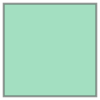

In [4]:
boundary_shape

In [5]:
def getGridGeoJSON(df,variable_name):
#     df = palau_eez(df)
    df_slice = df


    coordinates = df_slice[['lat','lon',variable_name]]
    coordinates = coordinates.drop_duplicates()

    colors = ['#c9f2f3',"#facd08","#faaa0a","#f00000","#960000"]
#     colors.reverse()
    levels = len(colors)
    vmin   = 0
    vmax   = 4
    tiers = np.linspace(vmin,vmax,levels+1).tolist()
 
    
    df_slice = df_slice.sort_values(by=['lon','lat'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.lat, df_slice.lon))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

        
    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = []
    
    for point in points_gdf.geometry:
#         if eez.contains(point) or point.within(eez):
        in_palau.append(point)
            
            
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["lon"] = longitude
    voronoi_poly["lat"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['lon','lat'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    values = df_slice[variable_name].tolist()
    
    df_colors = []
    
    for v in values:
        for i in range(len(tiers)):
            if tiers[i] > v:
                df_colors.append(colors[i-1])
                break
            if tiers[-1] <= v:
                df_colors.append(colors[-1])
                break
            if np.isnan(v):
                df_colors.append("#00000000")
#                 df_colors.append("#000000")
                break

    
    df_slice['fill'] = df_colors
    
    voronoi_color = GeoDataFrame(df_slice[['geometry','fill']],crs="EPSG:3395")
    
#     #Plotting voronoi
#     fig, ax = plt.subplots(figsize=(12, 10))
#     boundary.plot(ax=ax, color="gray")
#     voronoi_color.plot(ax=ax, color=voronoi_color["fill"])
#     points_gdf.plot(ax=ax, markersize=1, color="black")
#     ax.axis("off")
#     plt.axis('equal')
#     plt.show()
    
    #Plotting colorbar
#     cmap = mpl.colors.ListedColormap(colors)
#     bounds = [round(x,2) for x in tiers]
#     norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
#     cfig, ax = plt.subplots(figsize=(8,1))
#     cfig.subplots_adjust(bottom=0.5)
#     cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='horizontal', spacing='proportional',label="Sea Surface Temperature °C")
    
#     cfig.savefig("example.png")
    
    #Convert color to RGB

    R,G,B = [], [],[]
    for color in df_slice['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    df_slice['R'] = R
    df_slice['G'] = G
    df_slice['B'] = B
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('../palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
        
#     trimmed = trimmed[["geometry",variable_name,"fill", "R", "G", "B" ]]
    
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(50, 50))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
#     print(trimmed)
    
    json_gdf = trimmed.to_json()
    
    
    return json.loads(json_gdf)

In [6]:
def colorbar_mpl(full_directory):
#     df = palau_eez(df)
#     df_slice = df[df['year'] == time]


#     coordinates = df[['lat','lon',variable_name]]
#     coordinates = coordinates.drop_duplicates()

    colors = ['#c9f2f3',"#facd08","#faaa0a","#f00000","#960000"]
#     colors.reverse()
    levels = len(colors)
    vmin   = 0
    vmax   = 4
    cmap = mpl.colors.ListedColormap(colors)
#     tiers = np.linspace(vmin,vmax,levels+1).tolist()
    tiers = [0,1,2,3,4]
    
    
    bounds = [round(x,2) for x in tiers]

    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
    
    cfig, ax = plt.subplots(figsize=(8,1))
    cfig.subplots_adjust(bottom=0.5)
    cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='horizontal', spacing='proportional',label="Bleach Alert Level")
    
    cfig.savefig(full_directory)

In [47]:
df['CRW_BAA_Week_01-04']

0      NaN
1      NaN
2      0.0
3      0.0
4      0.0
      ... 
671    1.0
672    1.0
673    1.0
674    1.0
675    1.0
Name: CRW_BAA_Week_01-04, Length: 676, dtype: float32

In [71]:
print(max(df['lat'].tolist()))
print(min(df['lat'].tolist()))
print(max(df['lon'].tolist()))
print(min(df['lon'].tolist()))

13.75
1.25
140.25
127.75


In [97]:
df[['lat','lon','CRW_BAA_Week_01-04']]

,lat,lon,CRW_BAA_Week_01-04
0,1.25,127.75,NaN
1,1.25,128.25,NaN
2,1.25,128.75,0.0
3,1.25,129.25,0.0
4,1.25,129.75,0.0
...,...,...,...
671,13.75,138.25,1.0
672,13.75,138.75,1.0
673,13.75,139.25,1.0
674,13.75,139.75,1.0


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_42145/2777050200.py:118: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


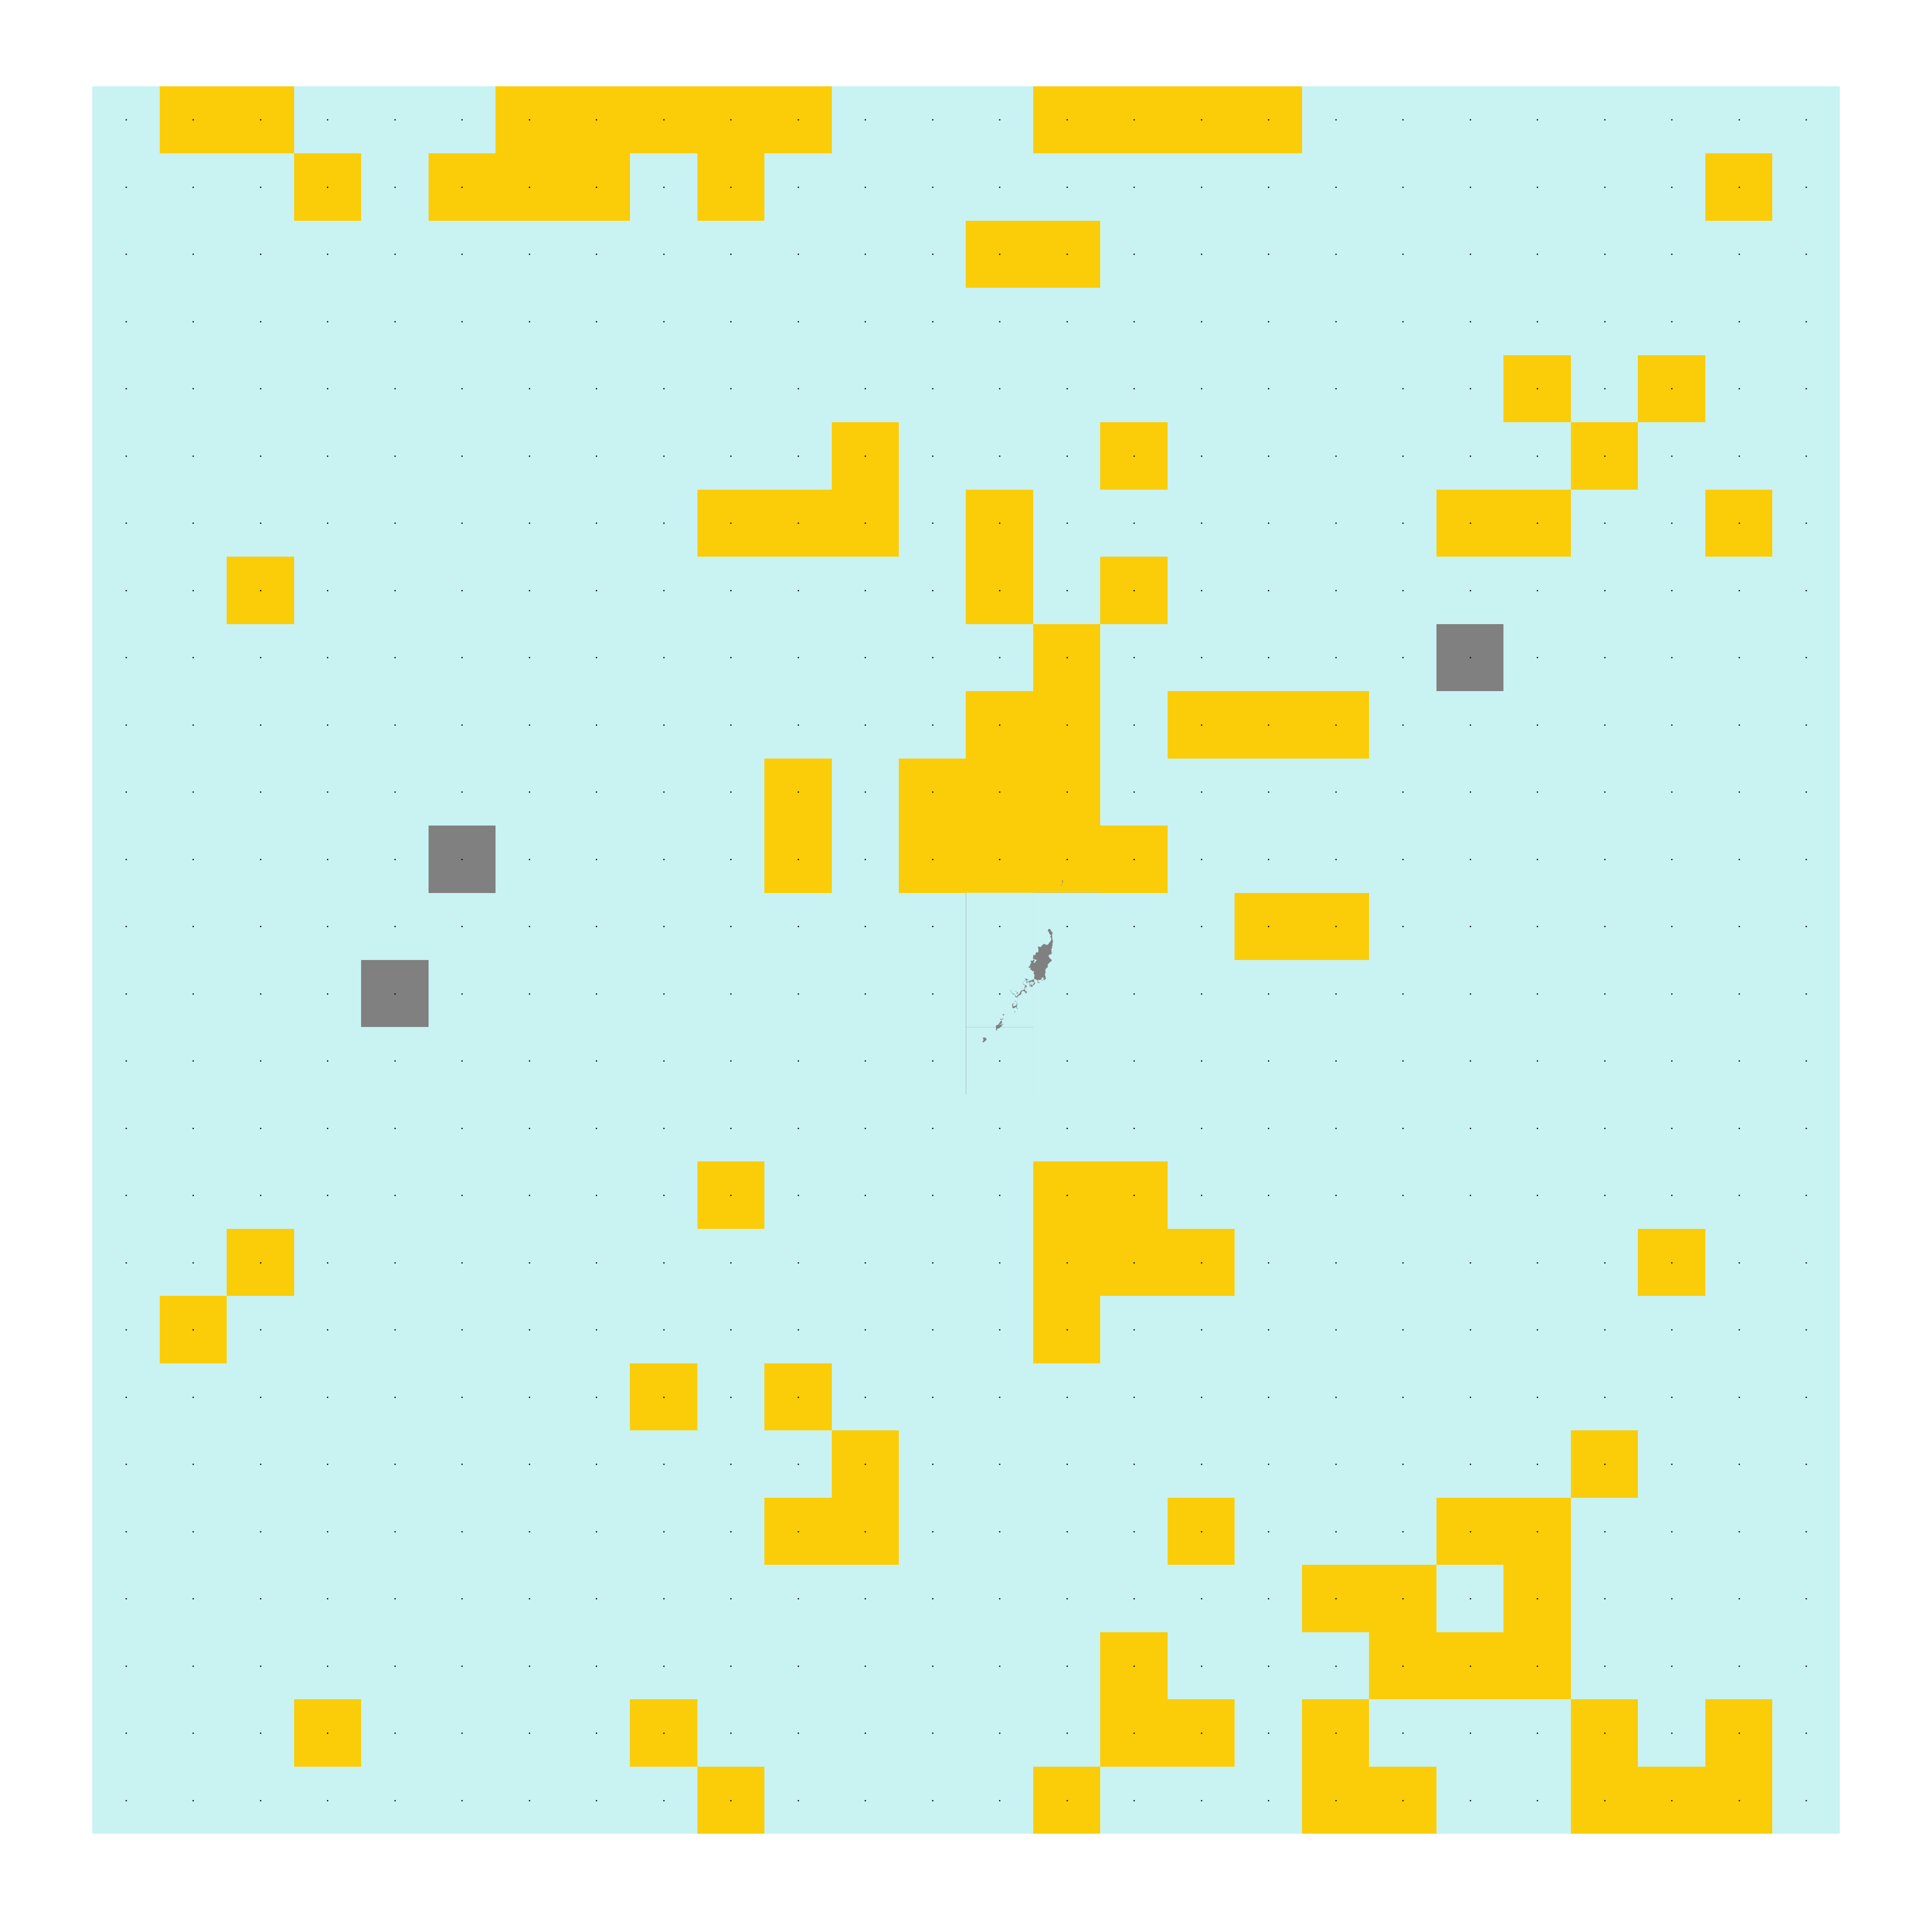

       lat     lon  CRW_BAA_Week_01-04  CRW_BAA_Week_05-08  \
0     1.25  140.25                 1.0                 1.0   
1     1.75  140.25                 0.0                 0.0   
2     2.25  140.25                 0.0                 0.0   
3     2.75  140.25                 0.0                 0.0   
4     3.25  140.25                 0.0                 0.0   
..     ...     ...                 ...                 ...   
671  11.75  127.75                 1.0                 0.0   
672  12.25  127.75                 0.0                 0.0   
673  12.75  127.75                 1.0                 0.0   
674  13.25  127.75                 1.0                 0.0   
675  13.75  127.75                 1.0                 0.0   

     CRW_BAA_Week_09-12                                           geometry  \
0                   1.0  POLYGON ((139.000 2.000, 139.000 1.500, 138.50...   
1                   1.0  POLYGON ((140.000 2.000, 140.000 1.500, 139.50...   
2                   0

In [105]:
getGridGeoJSON(df,'CRW_BAA_Week_09-12')

In [7]:
import warnings
warnings.filterwarnings(action='ignore')

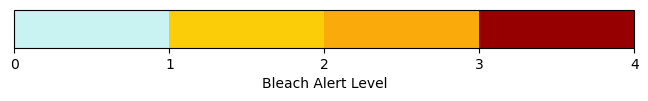

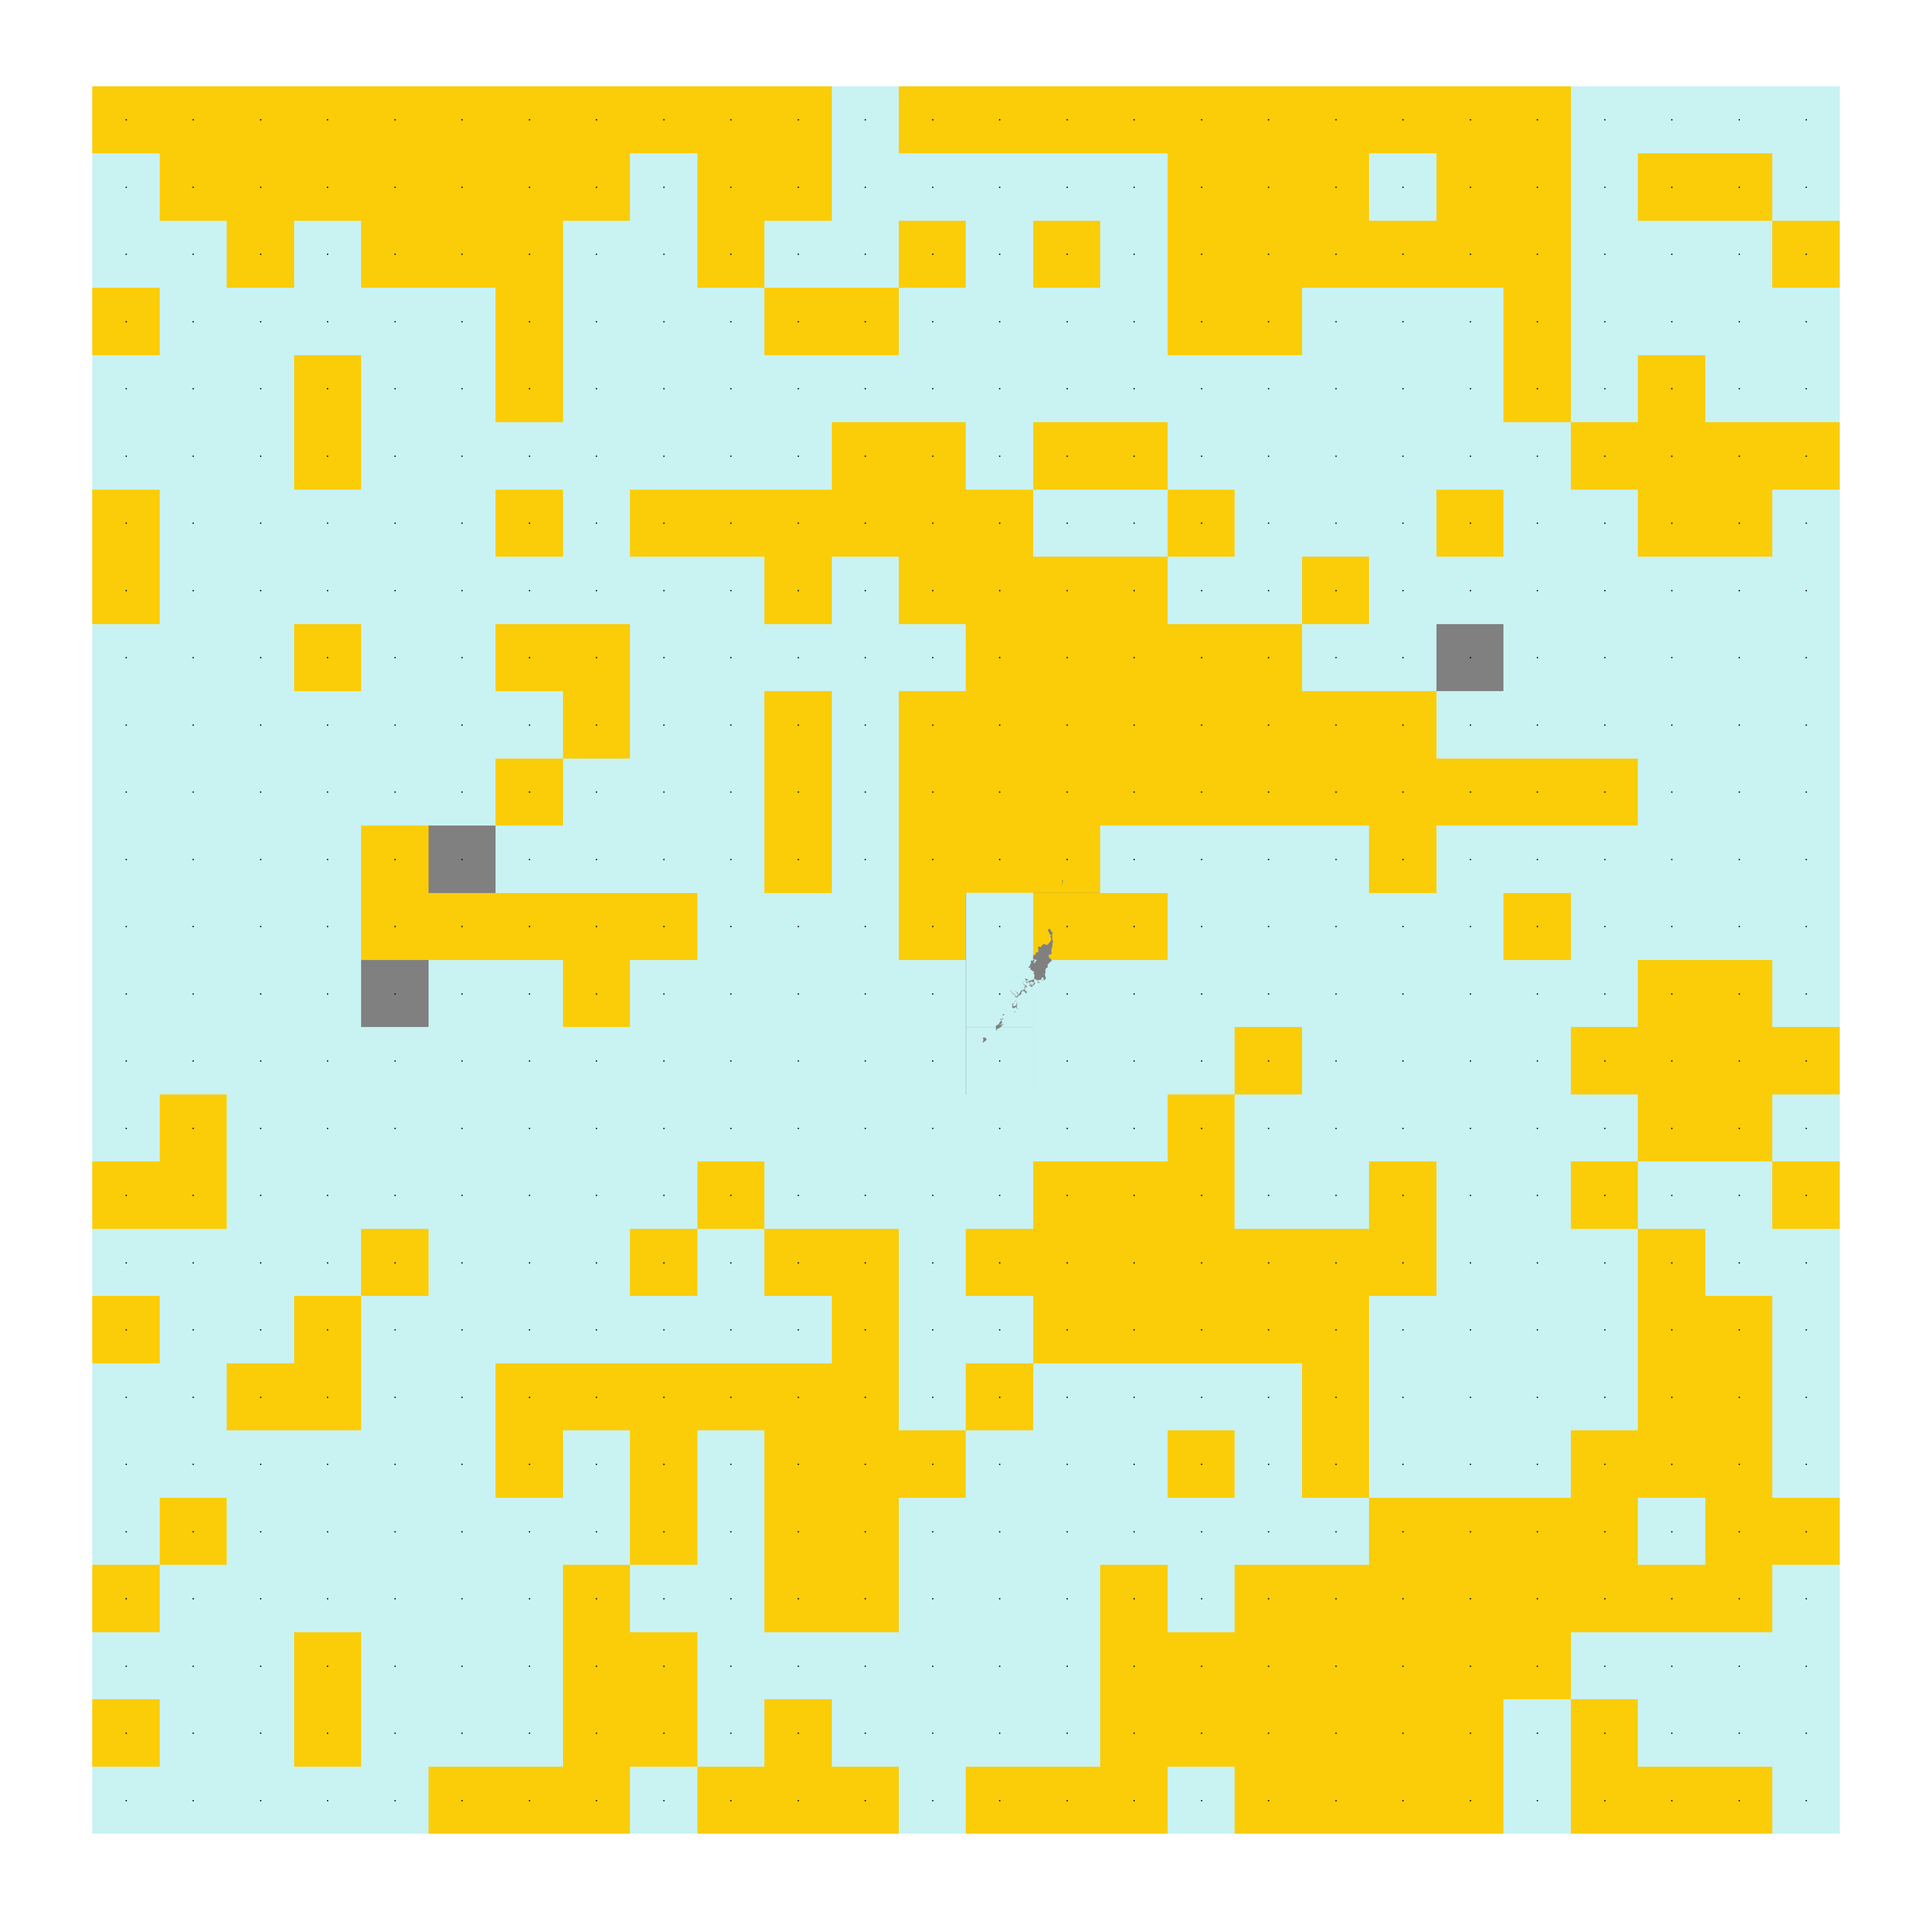

./CRW-Outlook/box/geojson/2011/CRW_BAA_Week_01-04/CRW_Gauge_box_2011-07-10.json


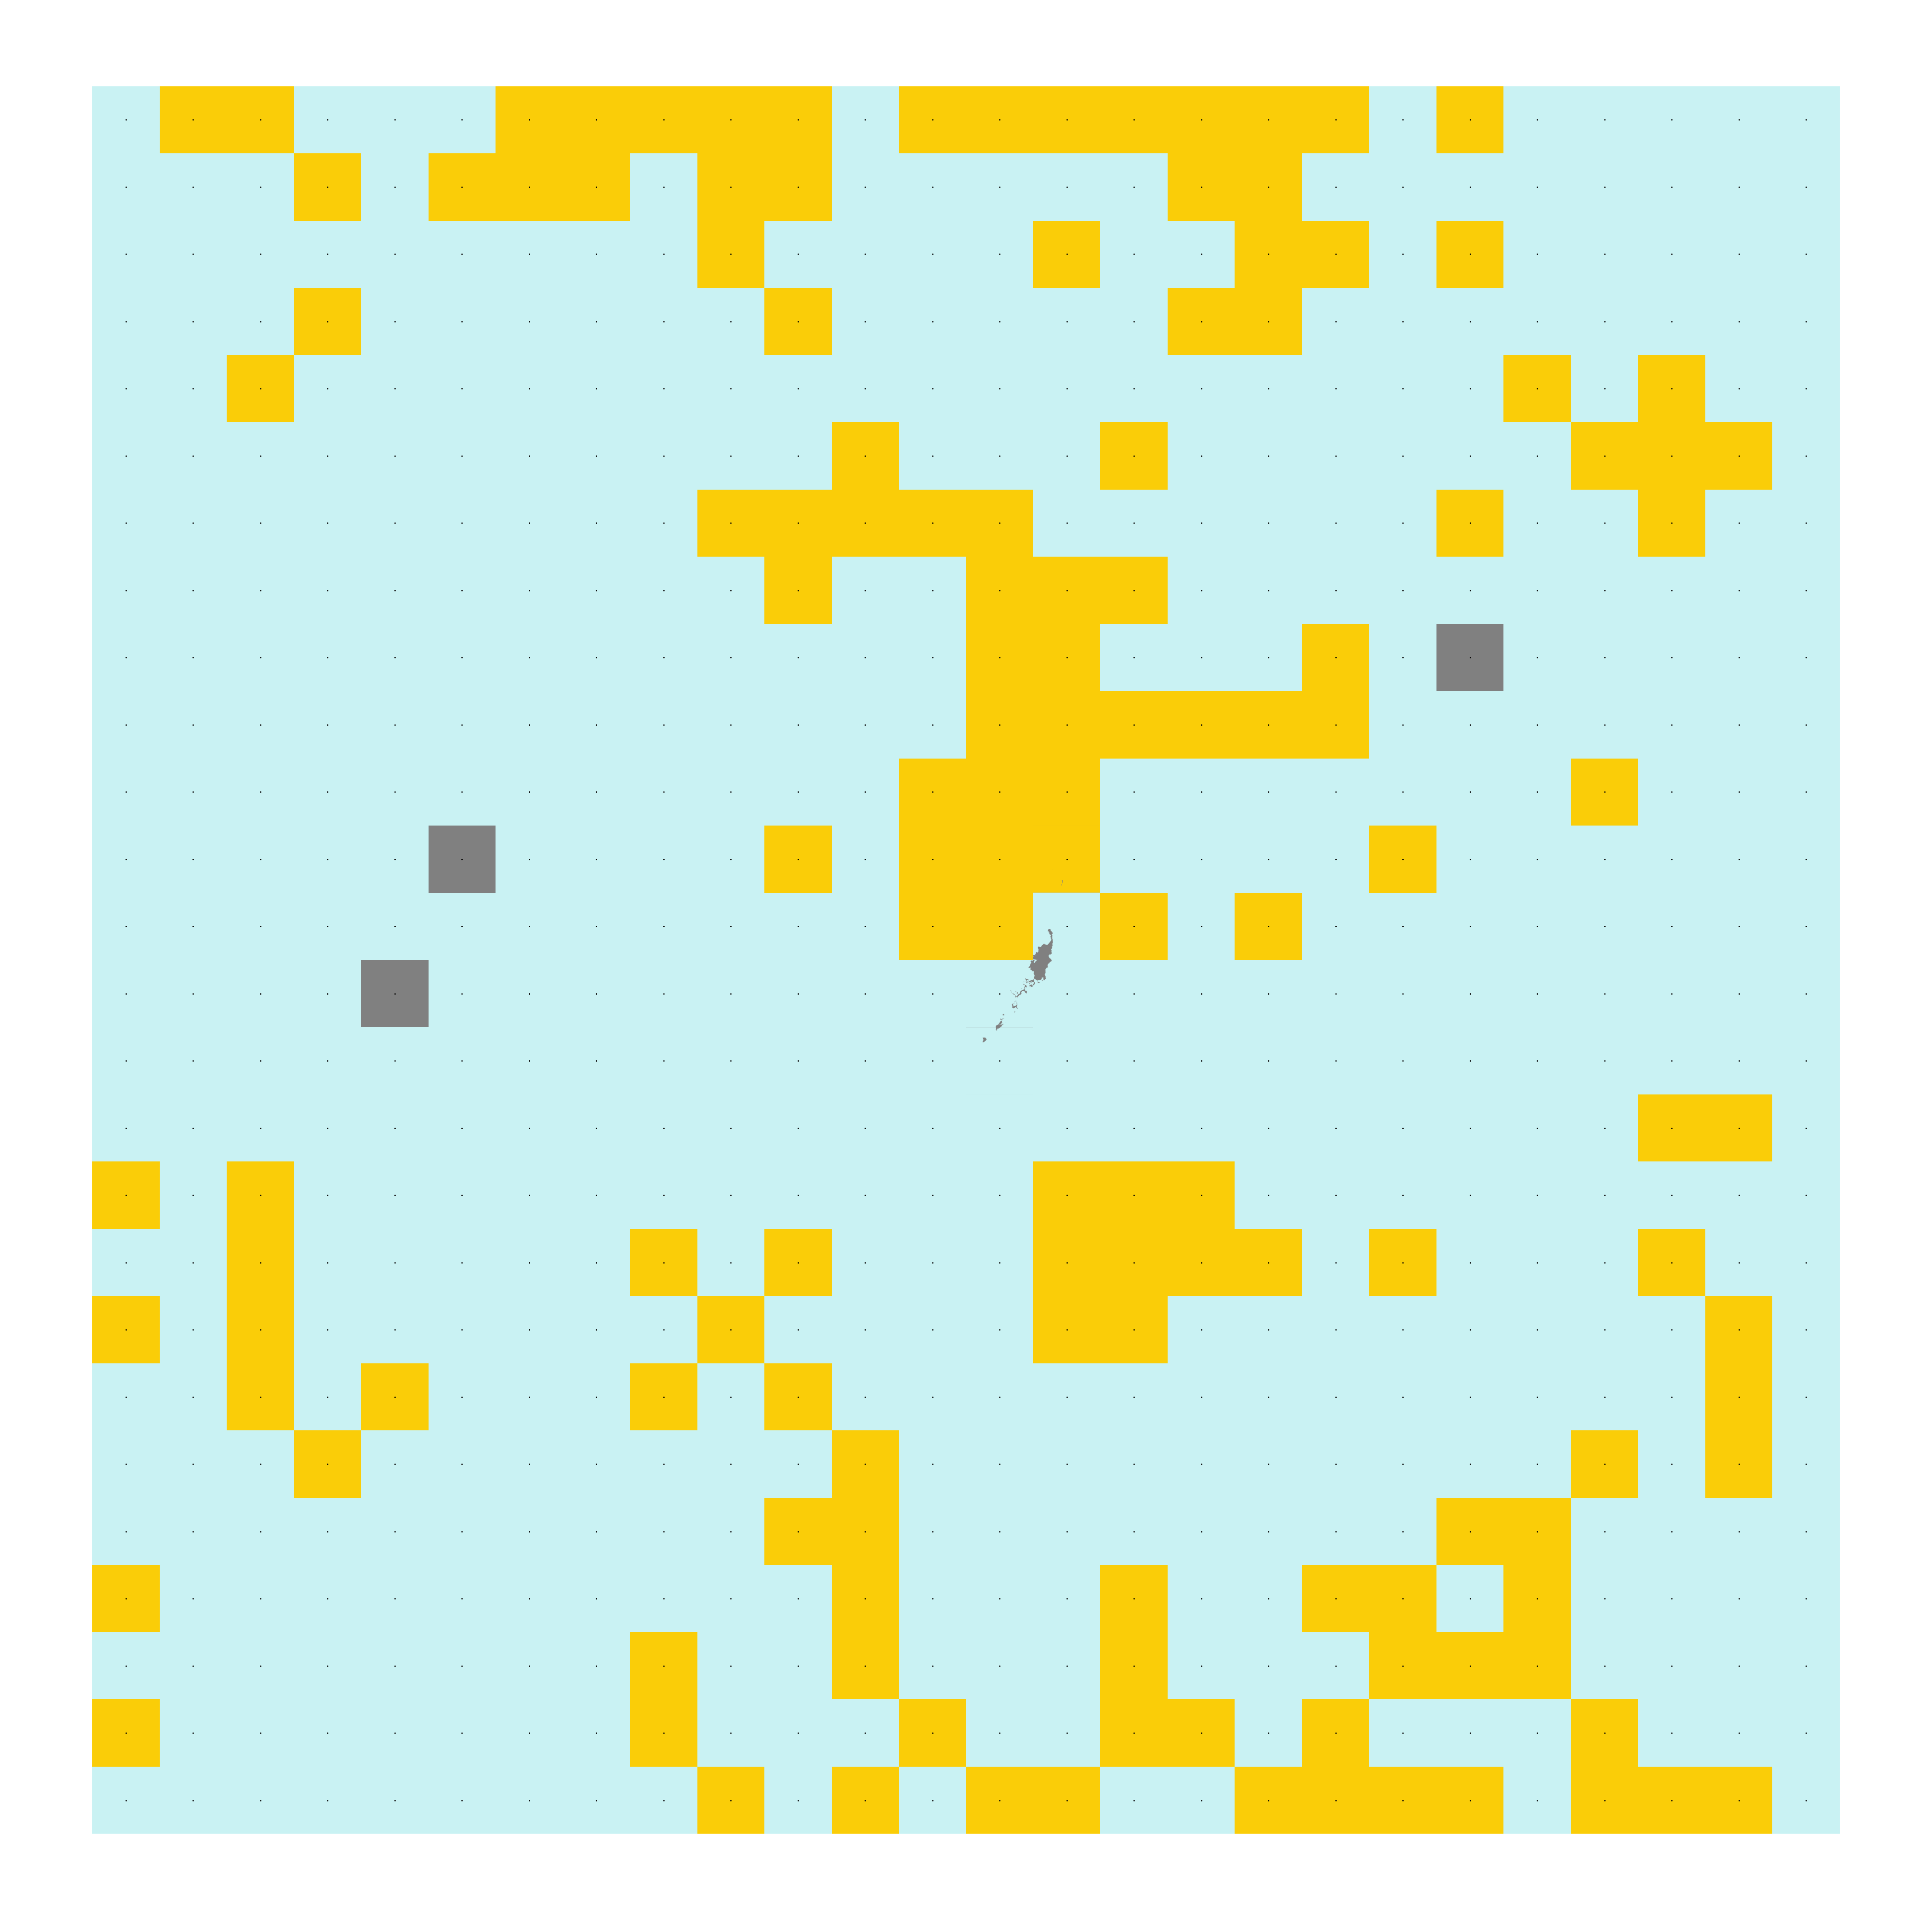

./CRW-Outlook/box/geojson/2011/CRW_BAA_Week_05-08/CRW_Gauge_box_2011-07-10.json


KeyboardInterrupt: 

In [23]:
if not os.path.exists('./CRW-Outlook/box/geojson'):
    os.makedirs('./CRW-Outlook/box/geojson')

if not os.path.exists('./CRW-Outlook/box/colorbar'):
    os.makedirs('./CRW-Outlook/box/colorbar')
    
colorbar_mpl('./CRW-Outlook/box/colorbar/CRW-Outlook.png')

pkl_folders = os.listdir('./CRW-Outlook/box/pkl')
pkl_folders.sort()



dials = ['CRW_BAA_Week_01-04','CRW_BAA_Week_05-08','CRW_BAA_Week_09-12']
for year in pkl_folders:
    if year != ".DS_Store":
        if not os.path.exists('./CRW-Outlook/box/geojson/'+ year):
            os.makedirs('./CRW-Outlook/box/geojson/'+ year)

        for time_range in dials:
            if not os.path.exists('./CRW-Outlook/box/geojson/'+ year + "/" + time_range):
                os.makedirs('./CRW-Outlook/box/geojson/'+ year + "/" + time_range)

        pkl_files = os.listdir('./CRW-Outlook/box/pkl/'+ year)
        pkl_files.sort()



        for file in pkl_files:
            df = pd.read_pickle('./CRW-Outlook/box/pkl/'+ year + '/' + file)
            df = df[['lat','lon','CRW_BAA_Week_01-04','CRW_BAA_Week_05-08','CRW_BAA_Week_09-12']]
            for time_range in dials:
                currgeo = getGridGeoJSON(df,time_range)
                json_object = json.dumps(currgeo, indent=4)
                geojson_dir = './CRW-Outlook/box/geojson/'+ year + "/" + time_range + "/" + file[:-4]+ ".json"
                with open(geojson_dir, "w") as outfile:
                    outfile.write(json_object)
                    print(geojson_dir)

In [24]:
df

,lat,lon,CRW_BAA_Week_01-04,CRW_BAA_Week_05-08,CRW_BAA_Week_09-12
0,1.25,127.75,NaN,NaN,NaN
1,1.25,128.25,NaN,NaN,NaN
2,1.25,128.75,0.0,0.0,0.0
3,1.25,129.25,0.0,0.0,0.0
4,1.25,129.75,0.0,0.0,0.0
...,...,...,...,...,...
671,13.75,138.25,1.0,1.0,1.0
672,13.75,138.75,1.0,1.0,1.0
673,13.75,139.25,1.0,1.0,1.0
674,13.75,139.75,1.0,1.0,1.0


In [40]:
"asdfa2014"[-4:]

'2014'

In [41]:
year

'2011'

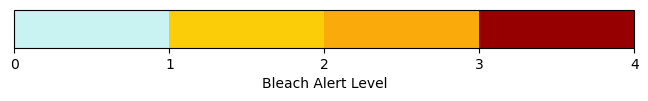

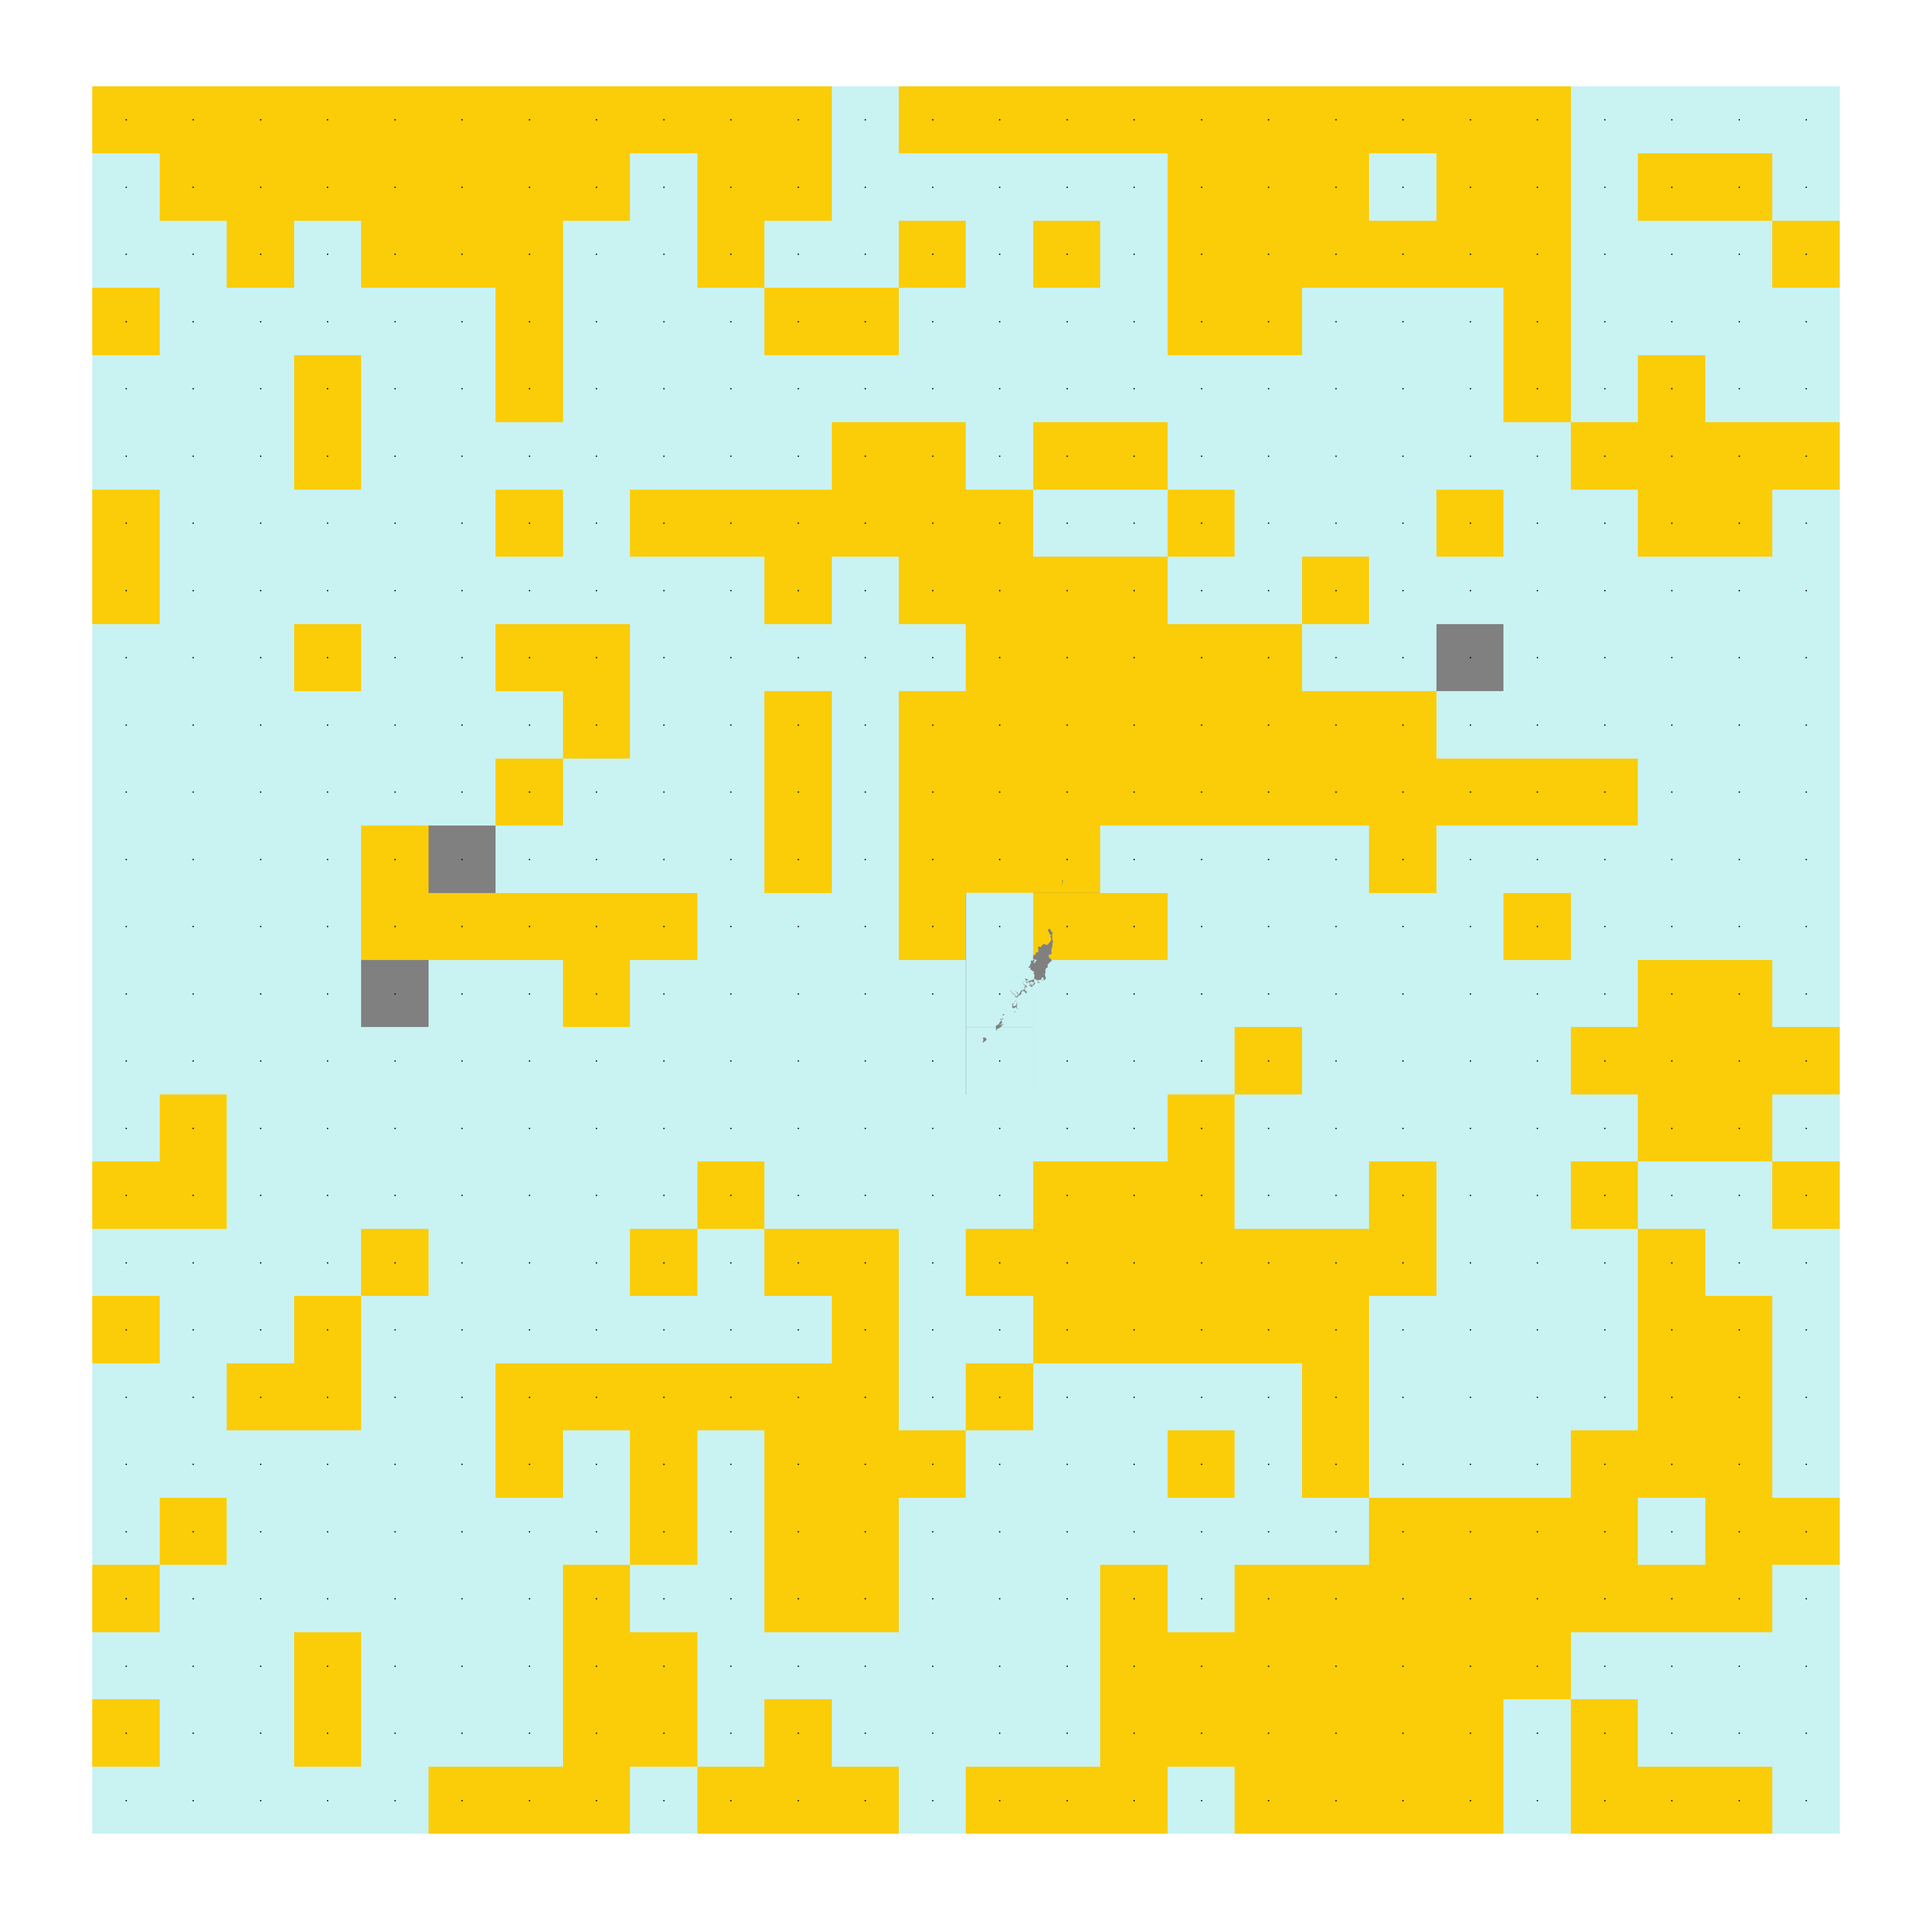

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Week_01-04/2011-07-10.json


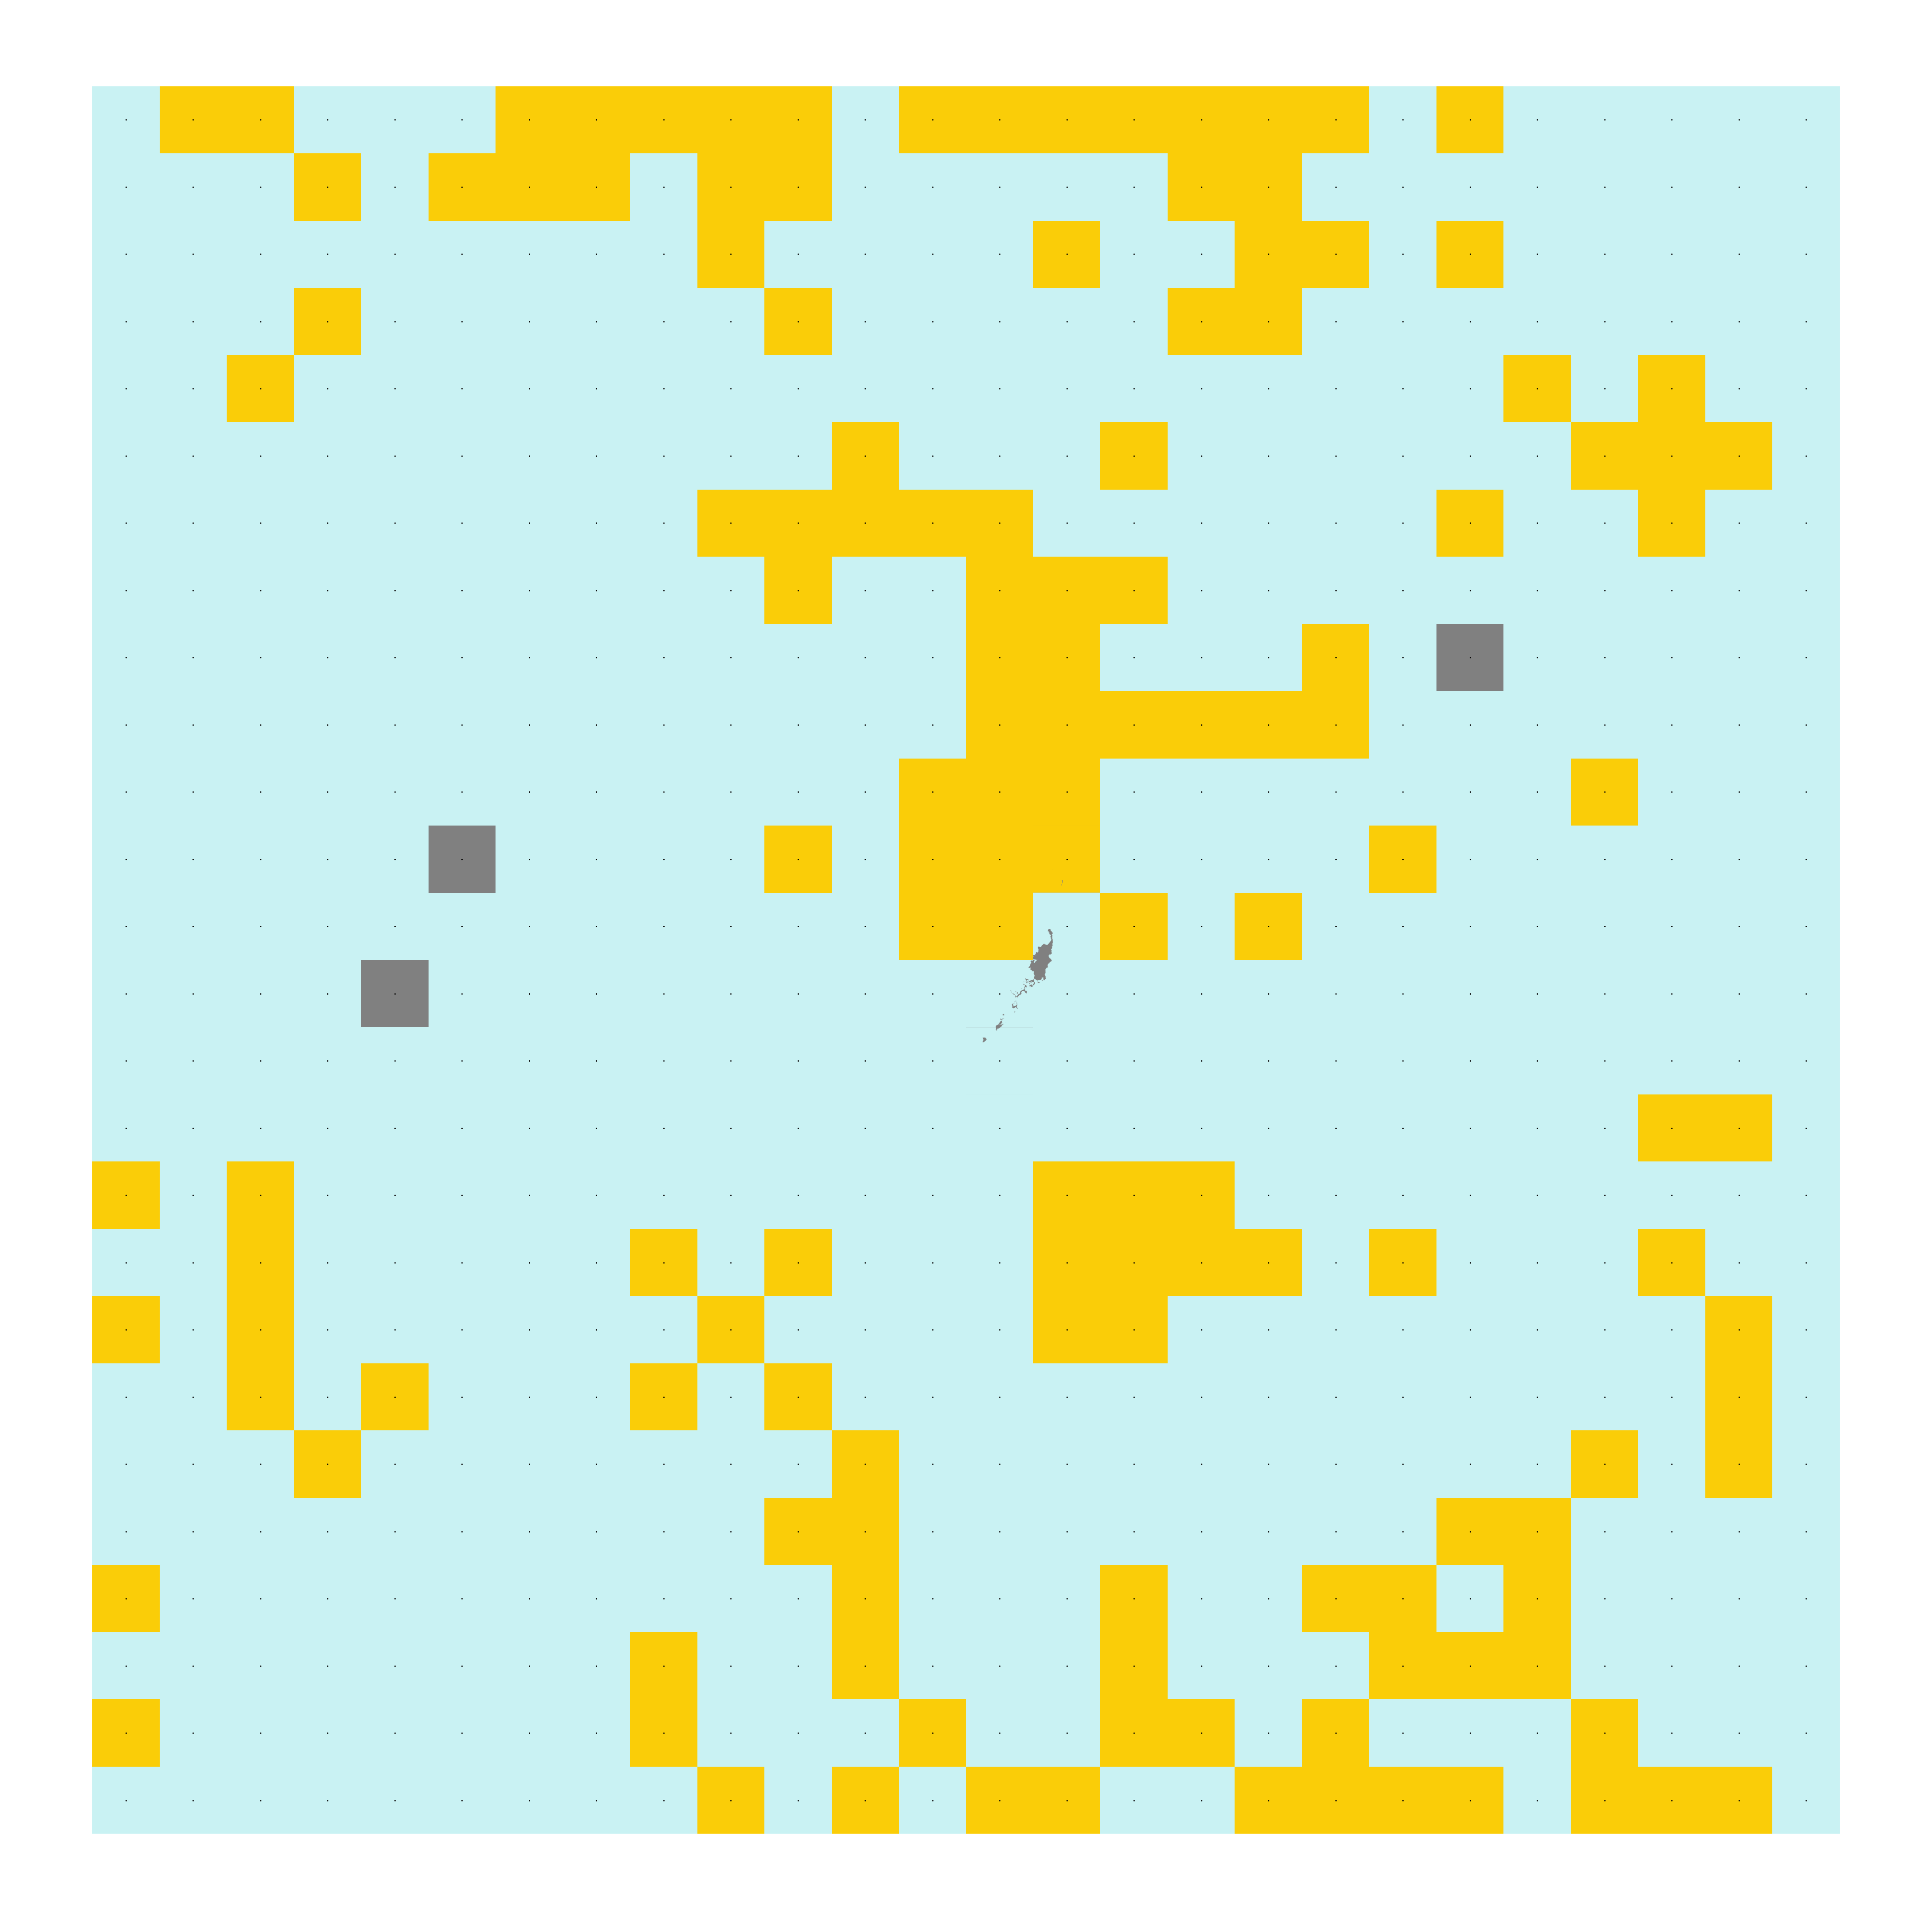

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Week_05-08/2011-07-10.json


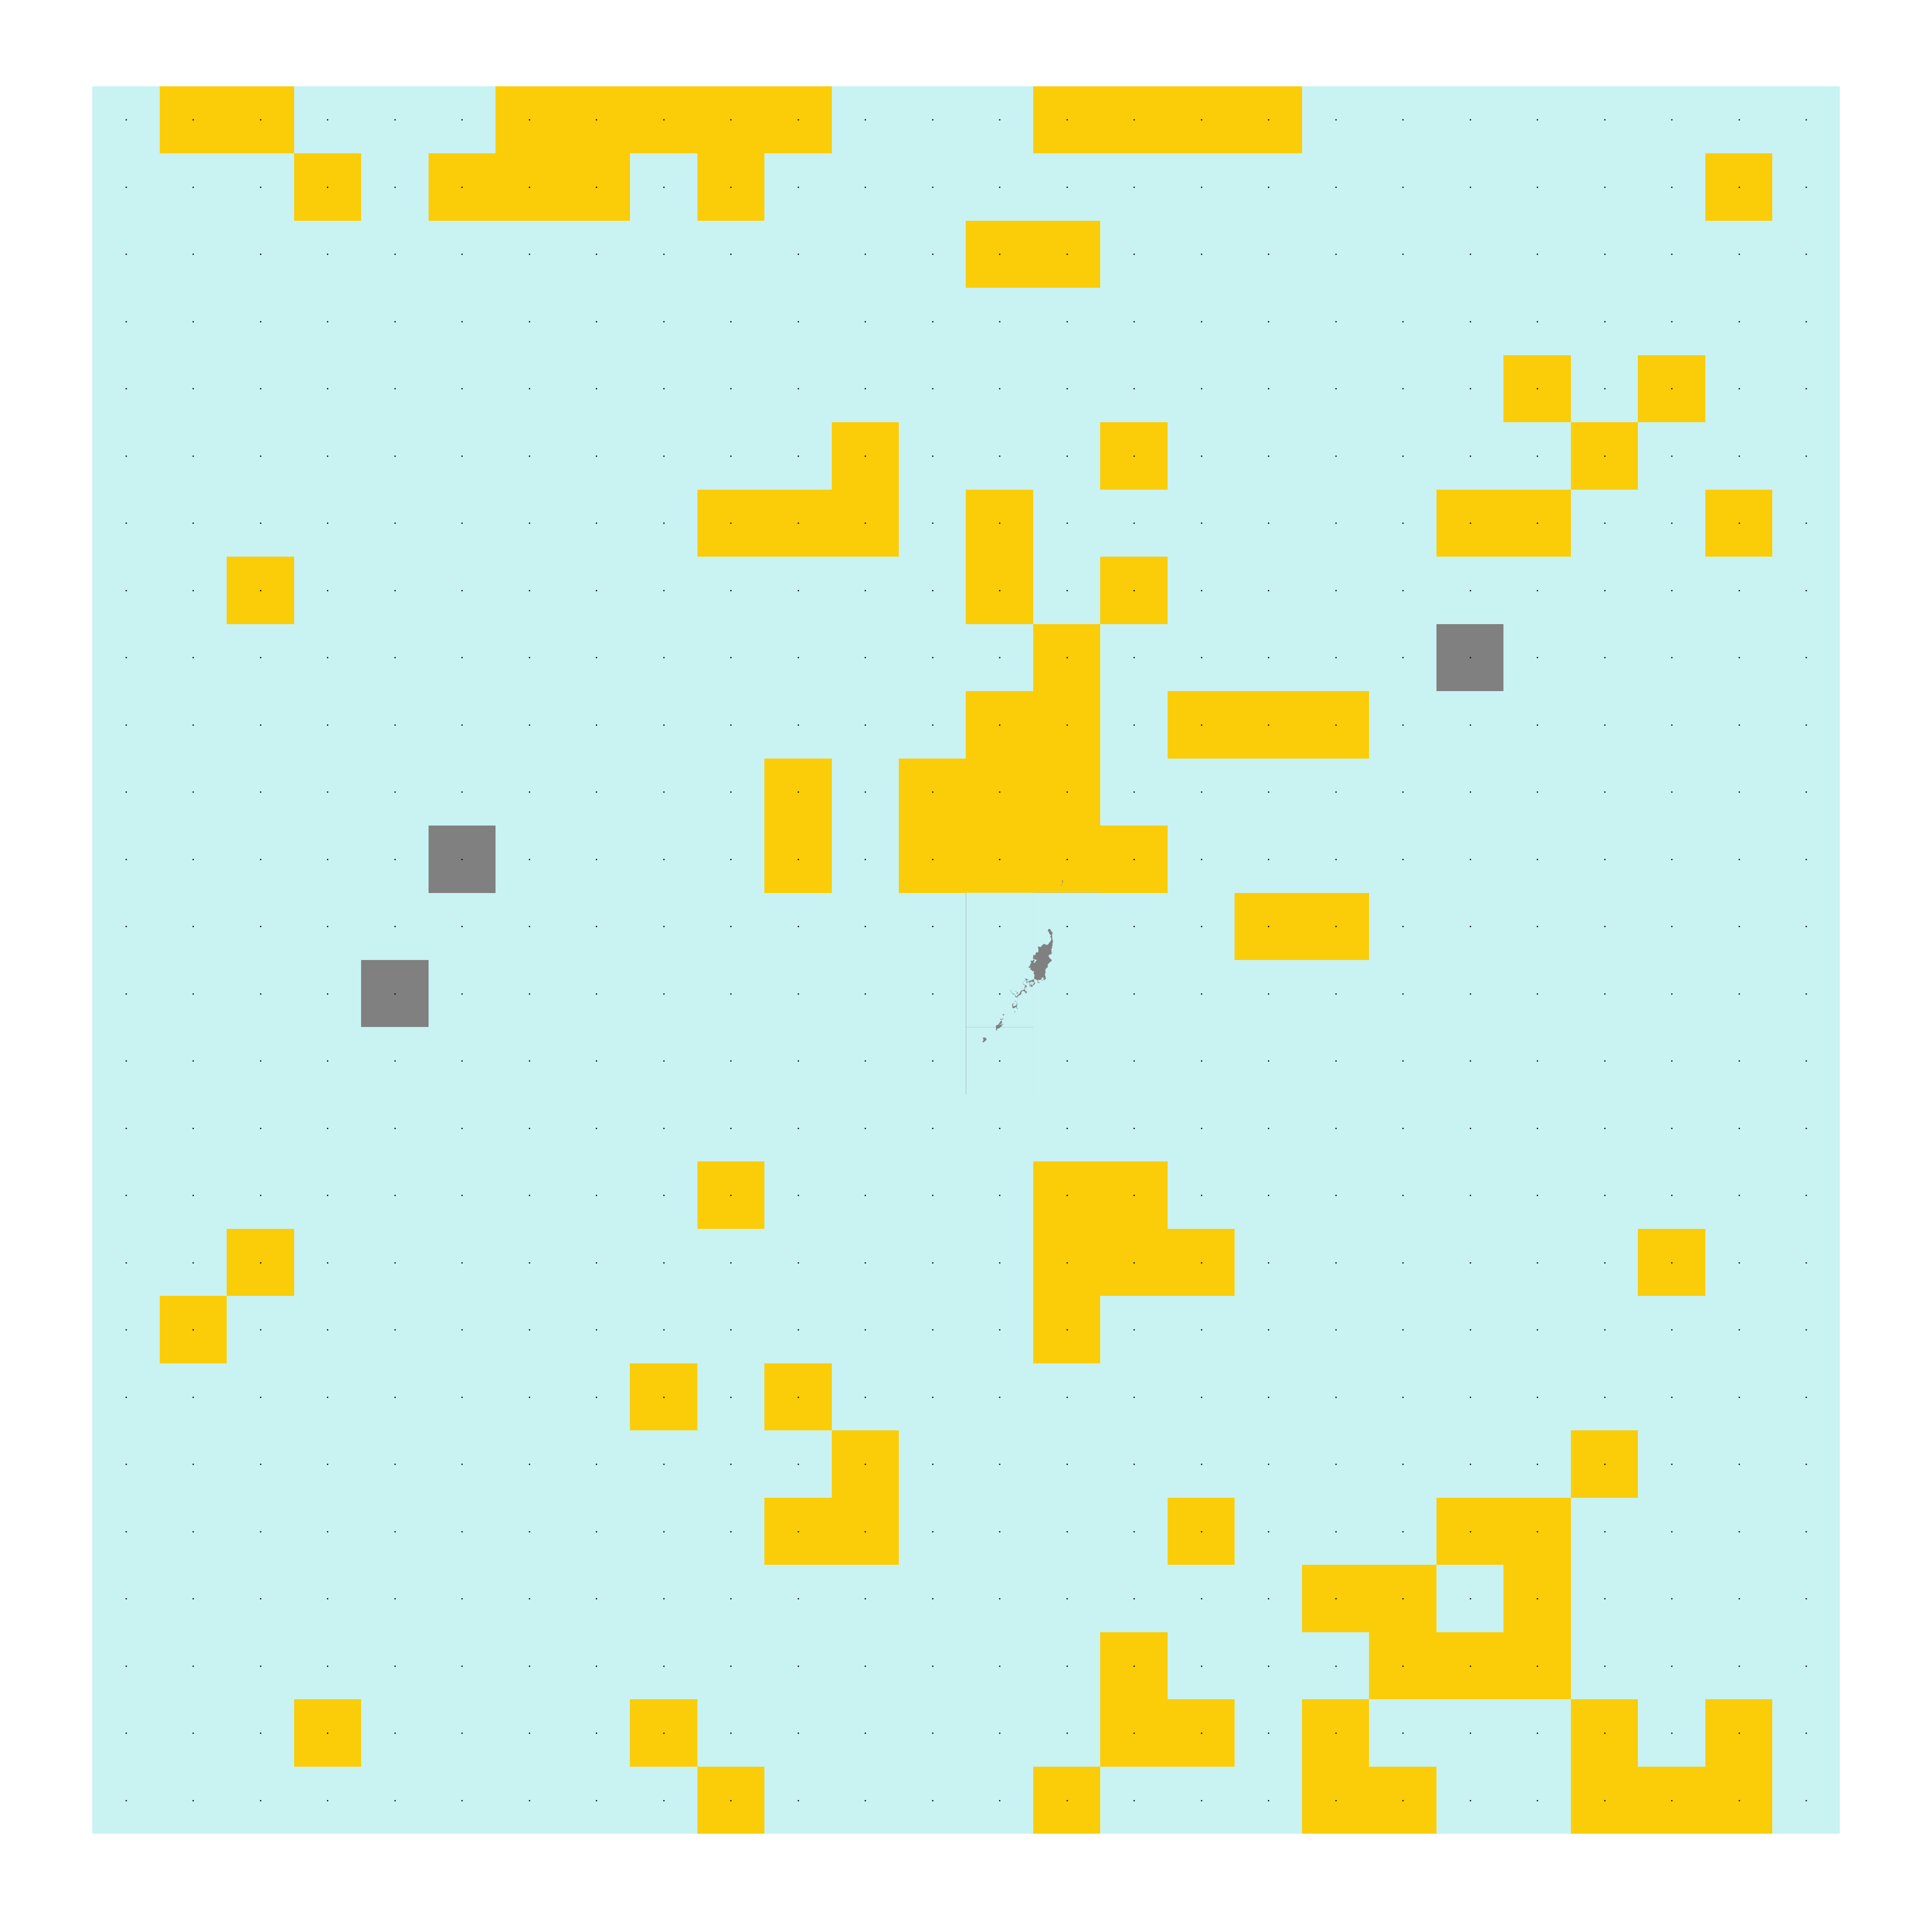

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Week_09-12/2011-07-10.json


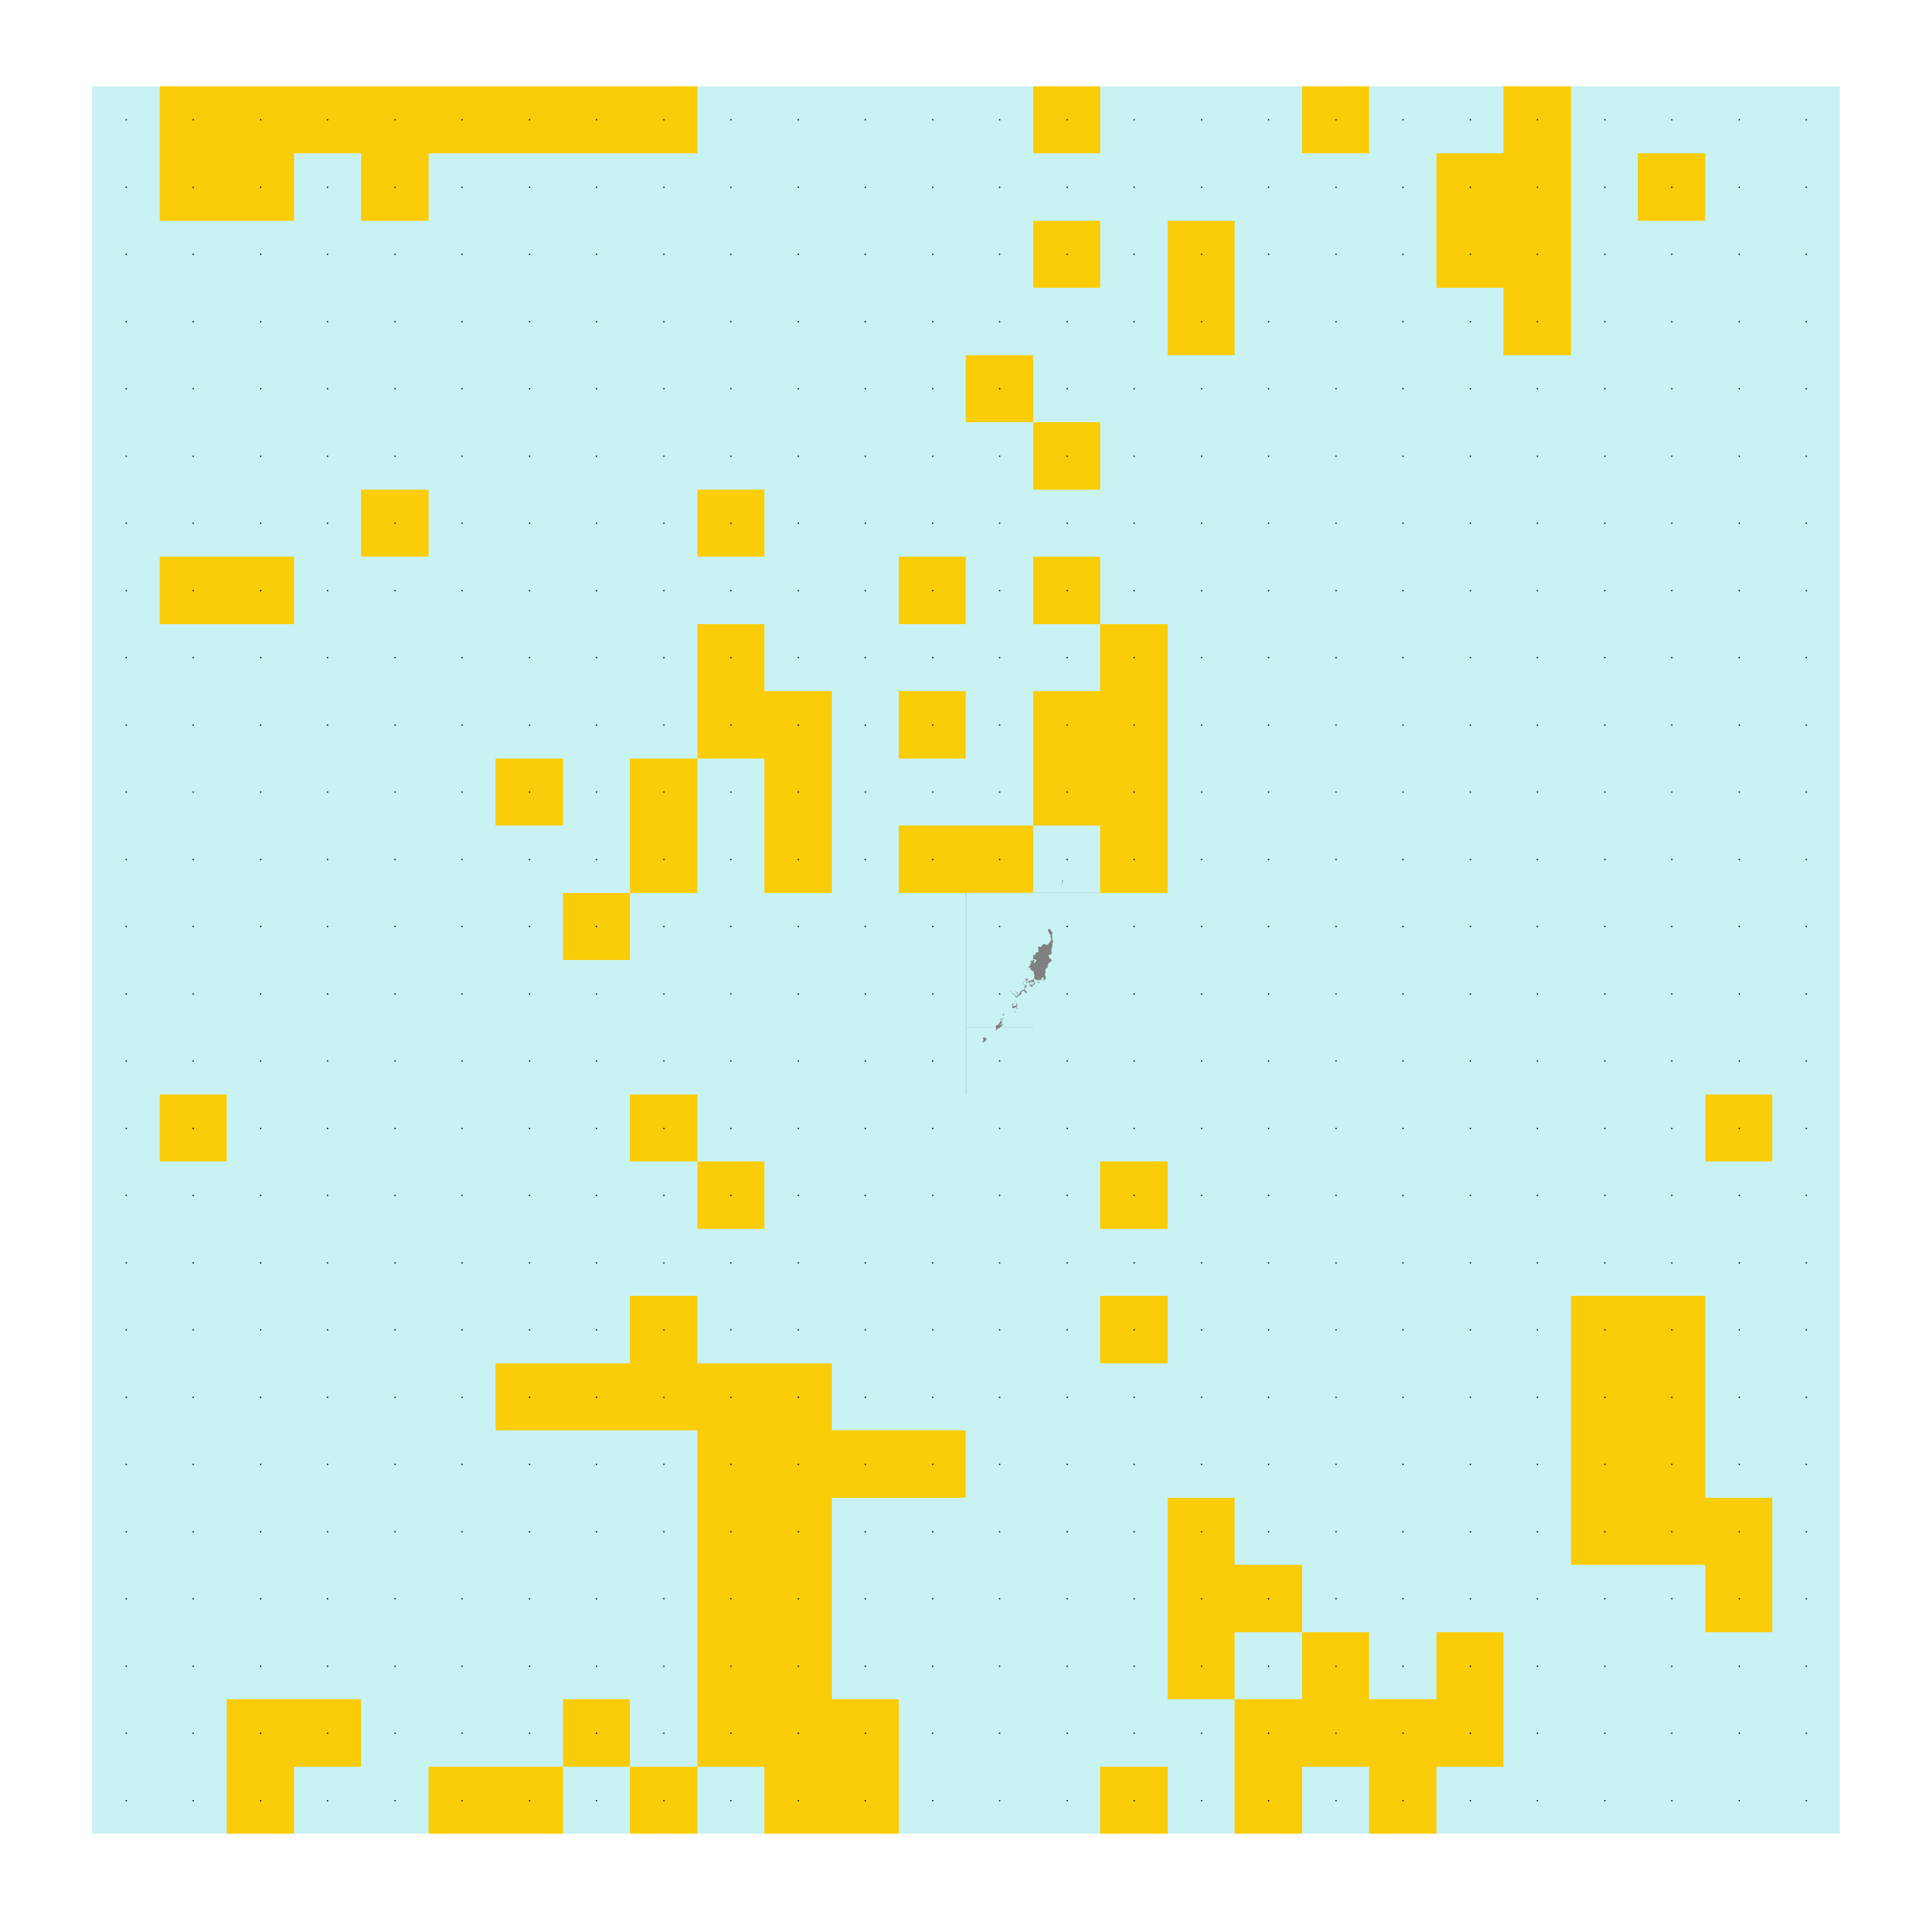

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Current_Rounded/2011-07-10.json


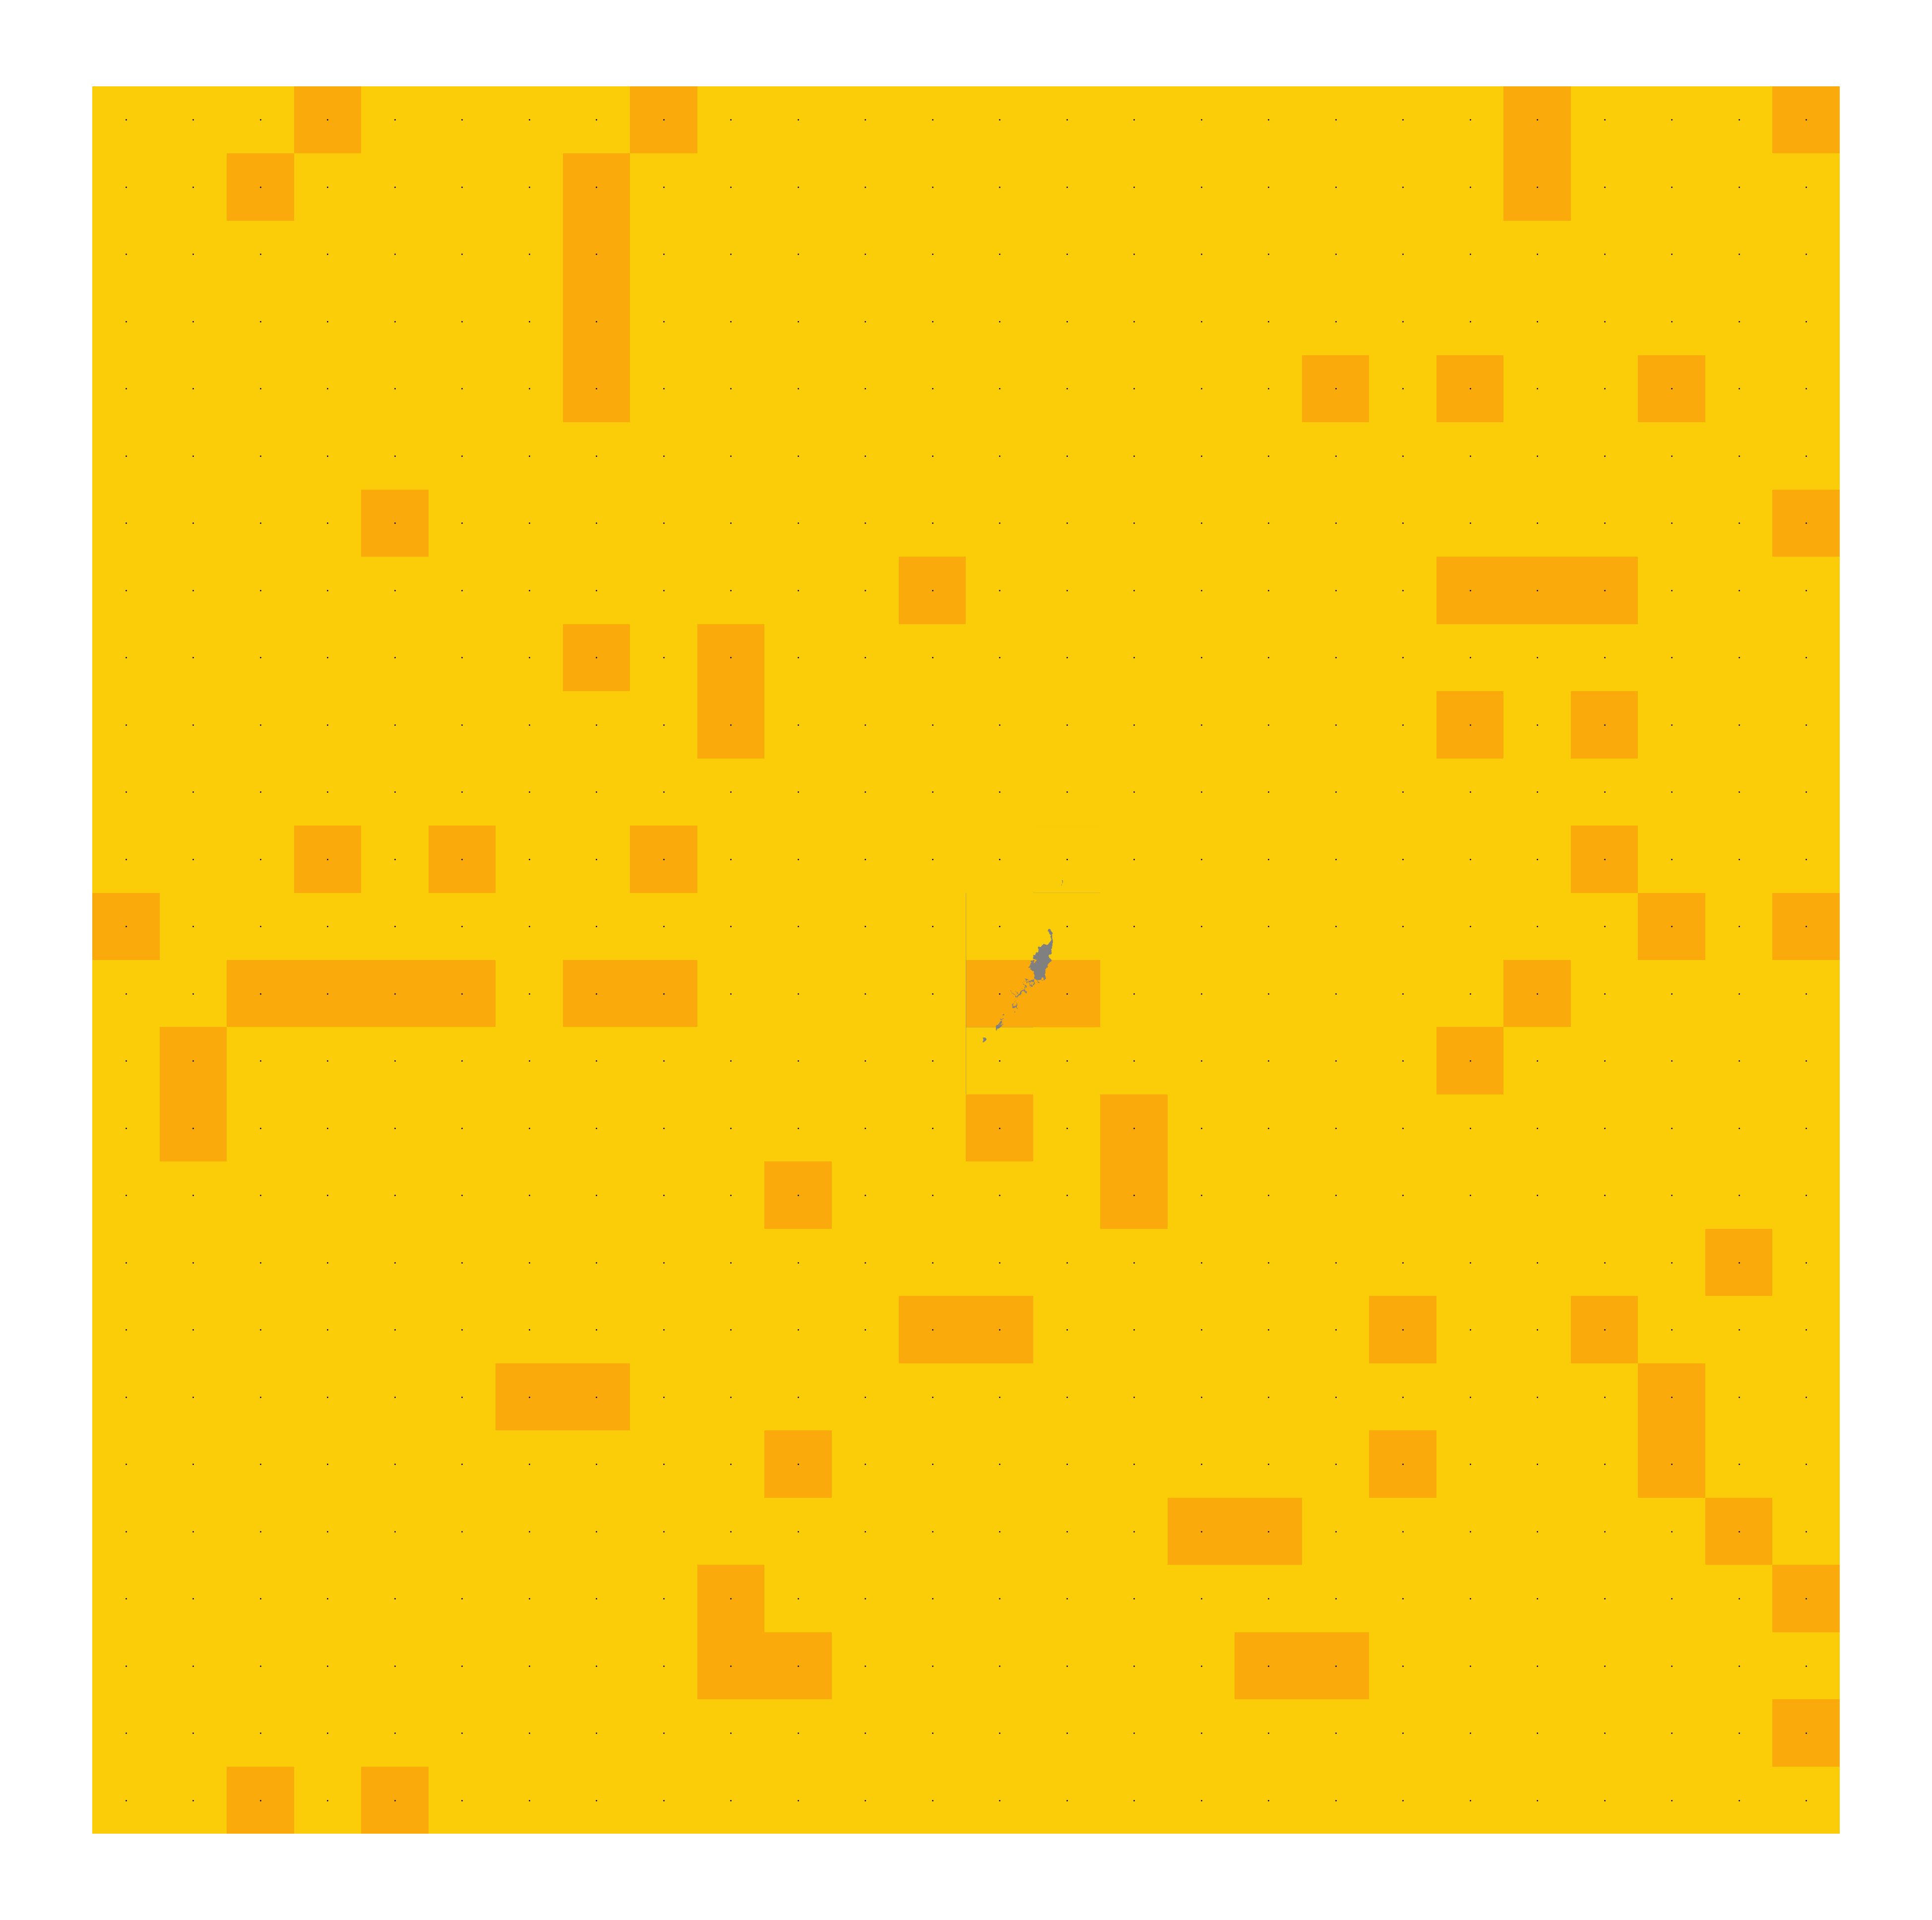

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Current_Max/2011-07-10.json


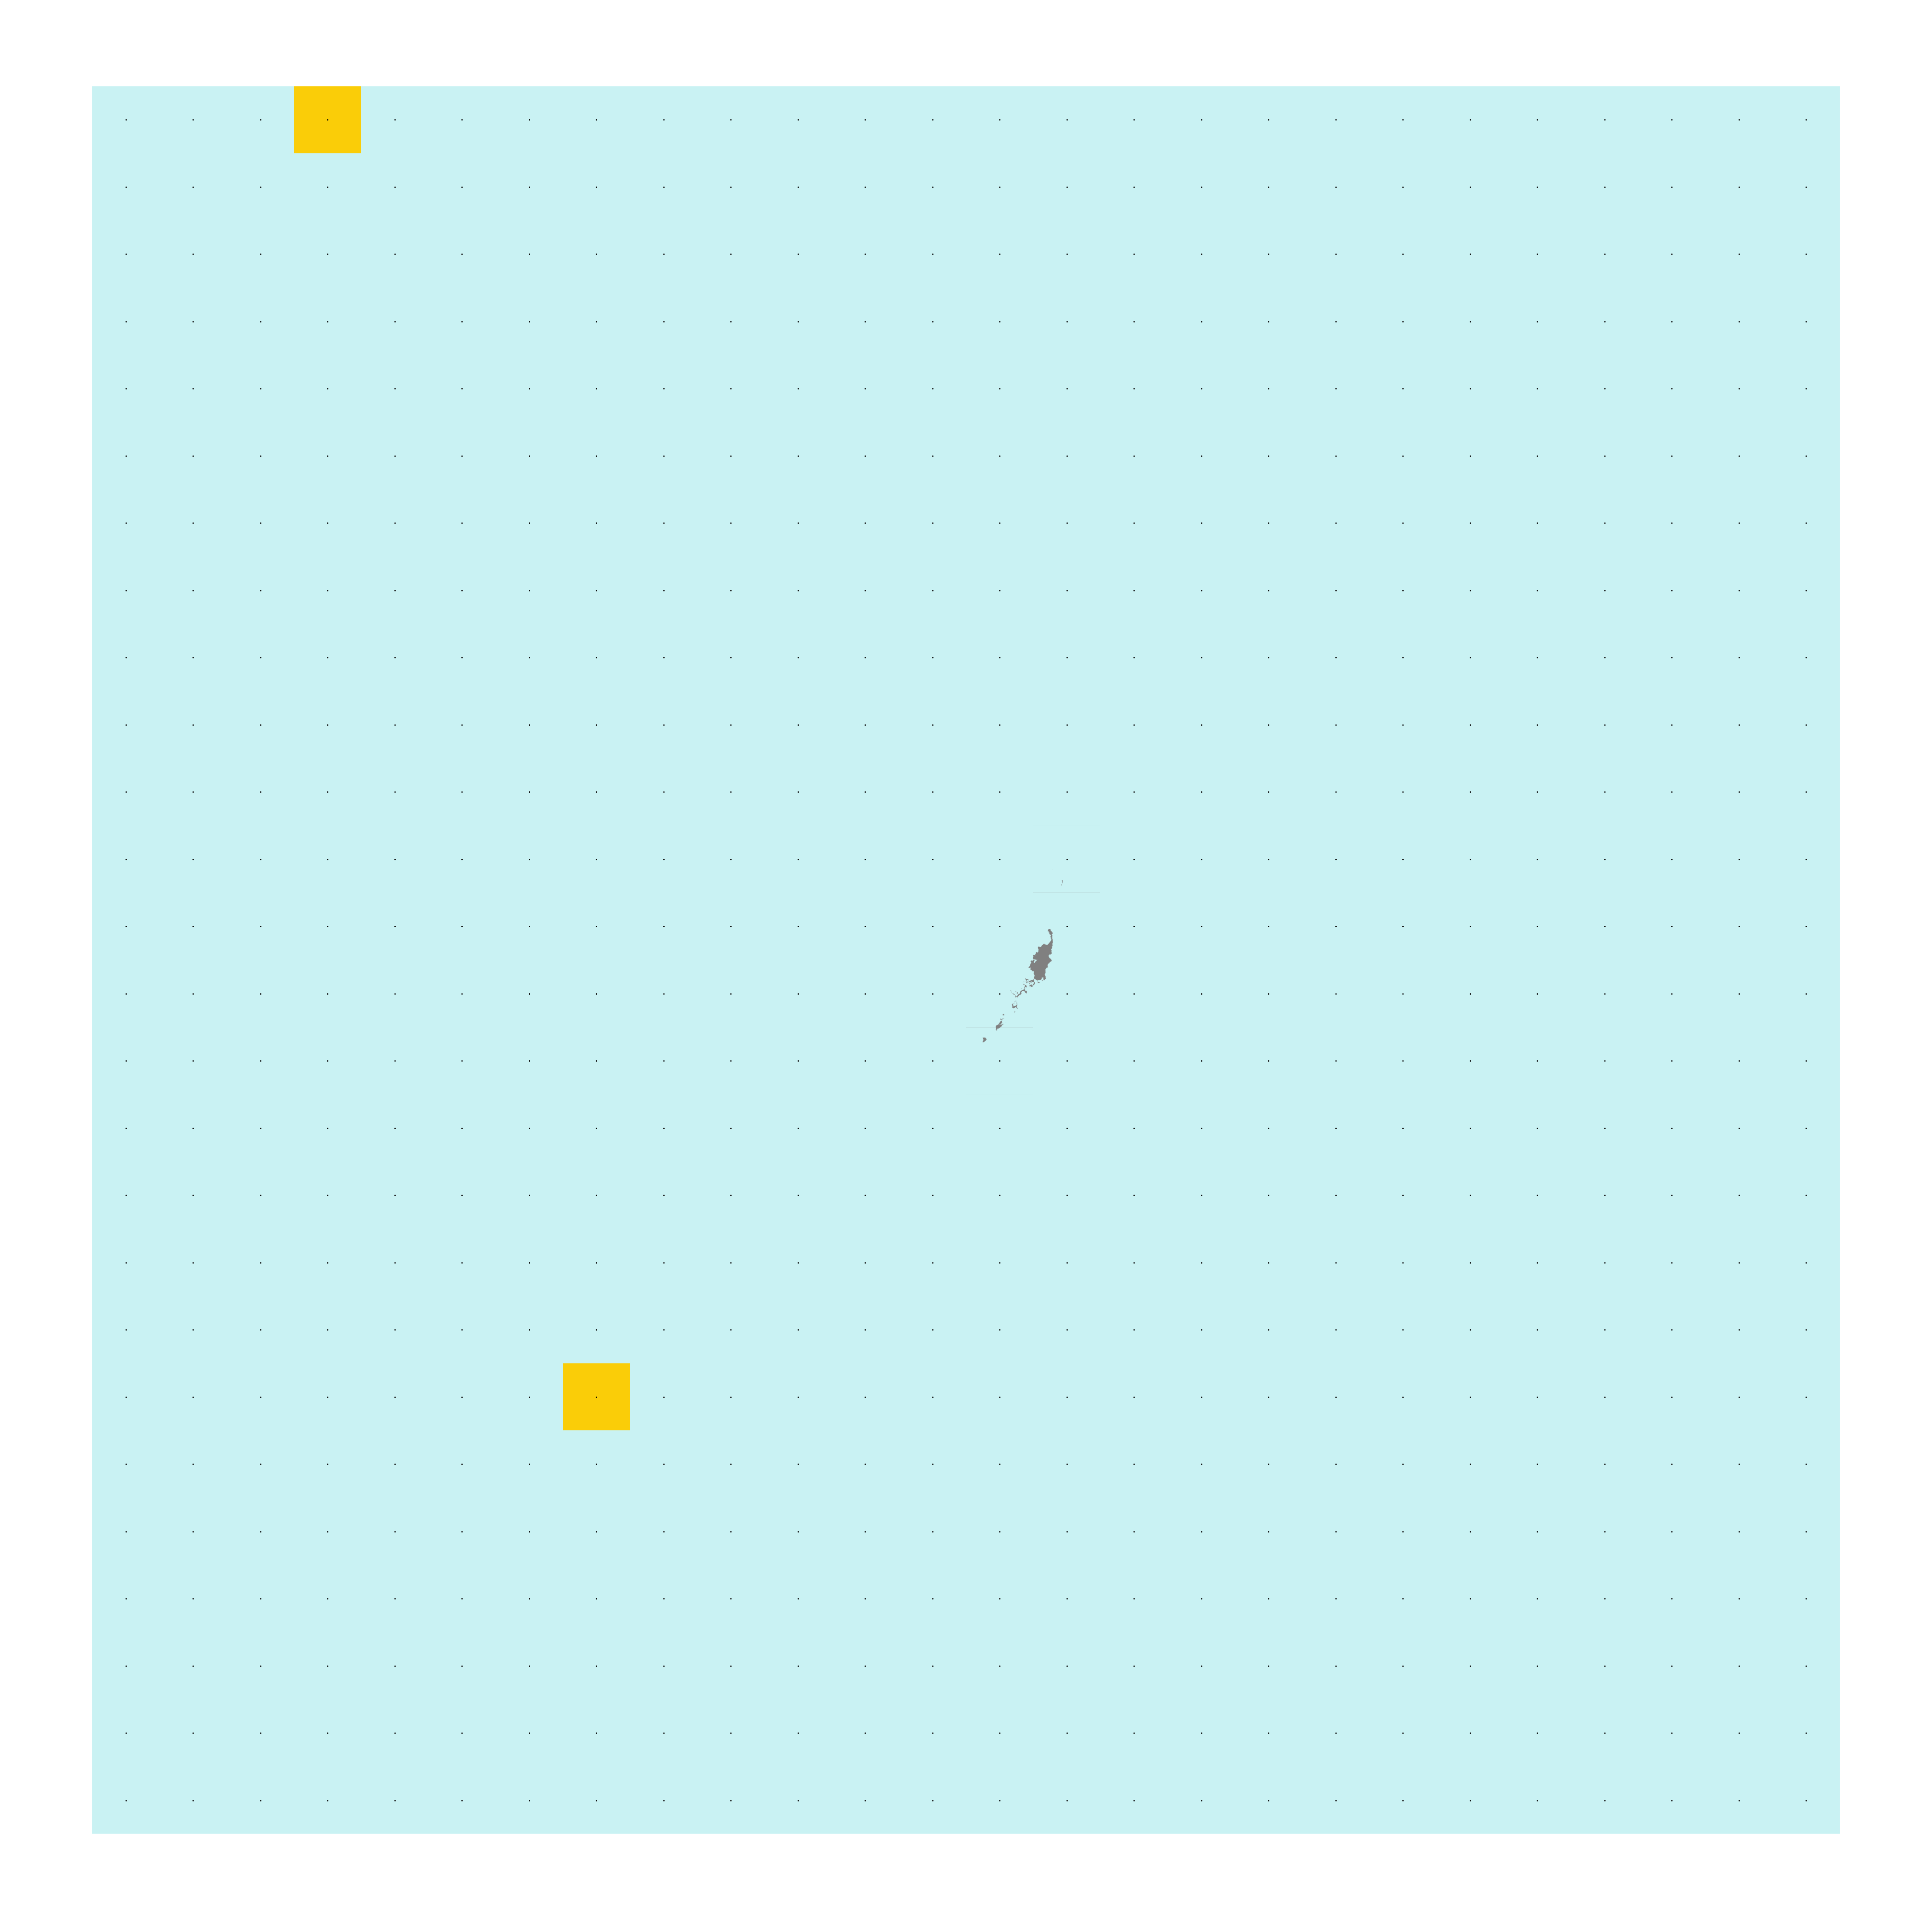

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Current_Mean/2011-07-10.json


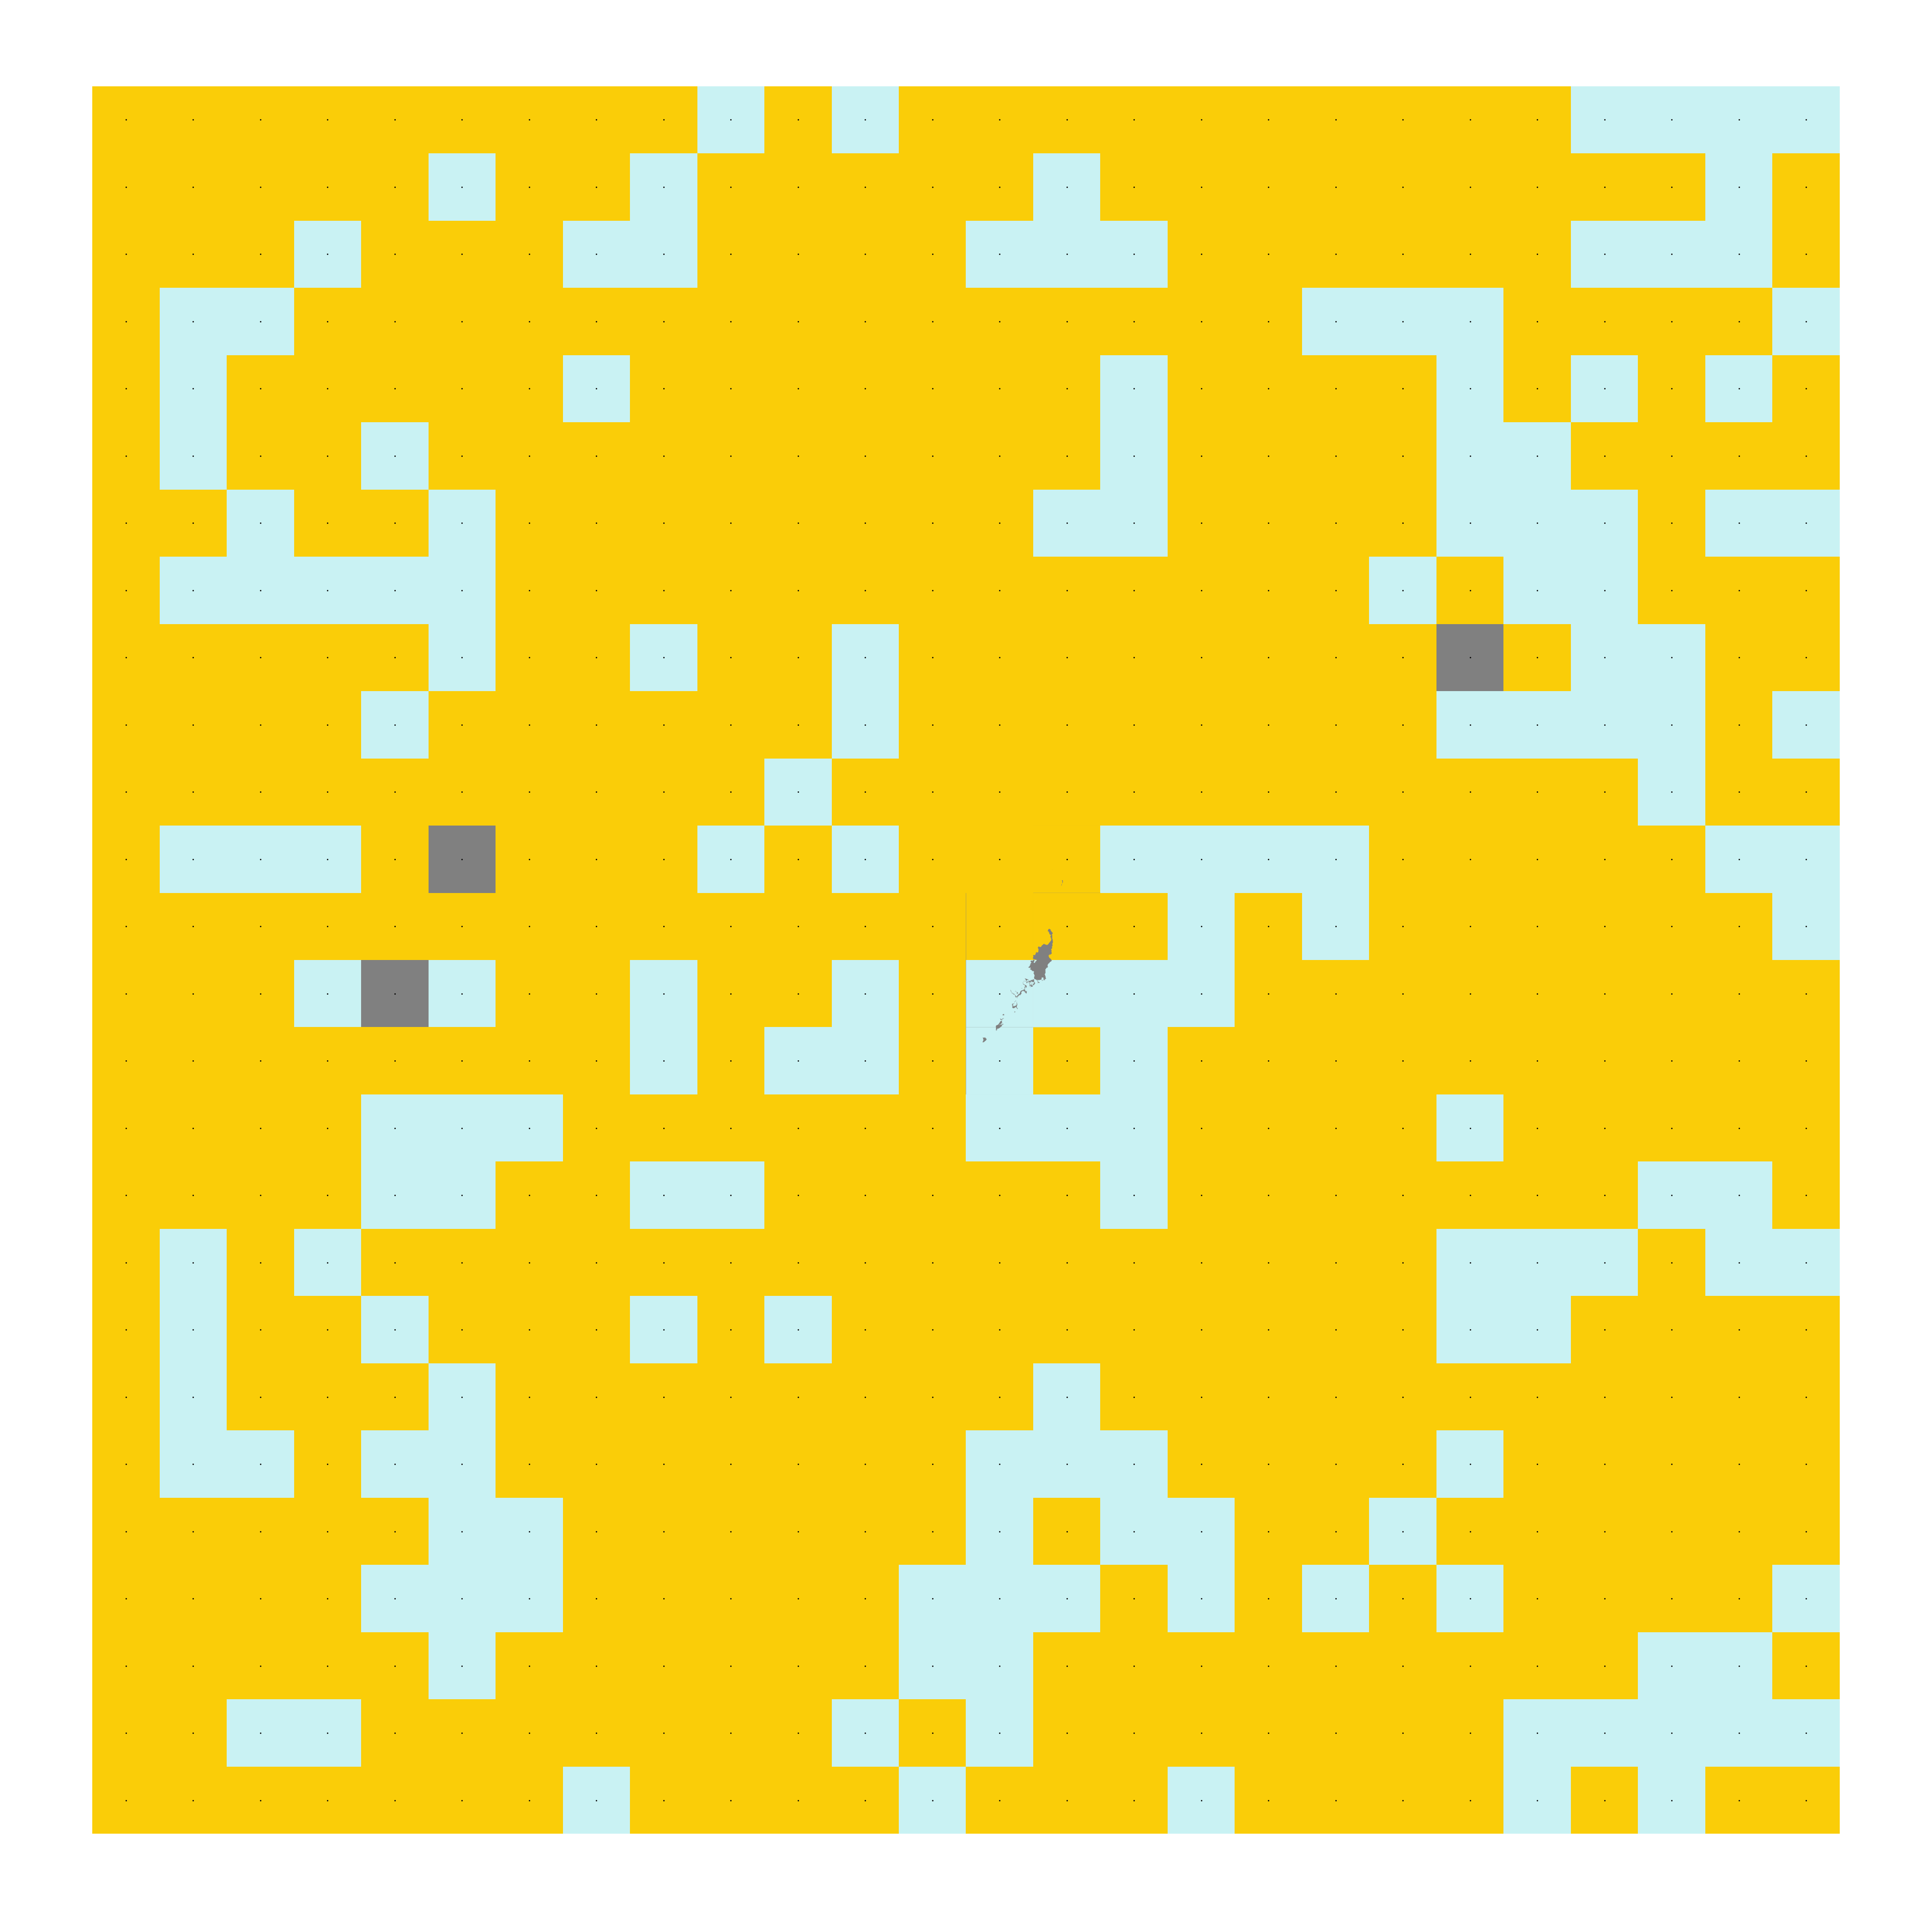

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Week_01-04/2011-07-17.json


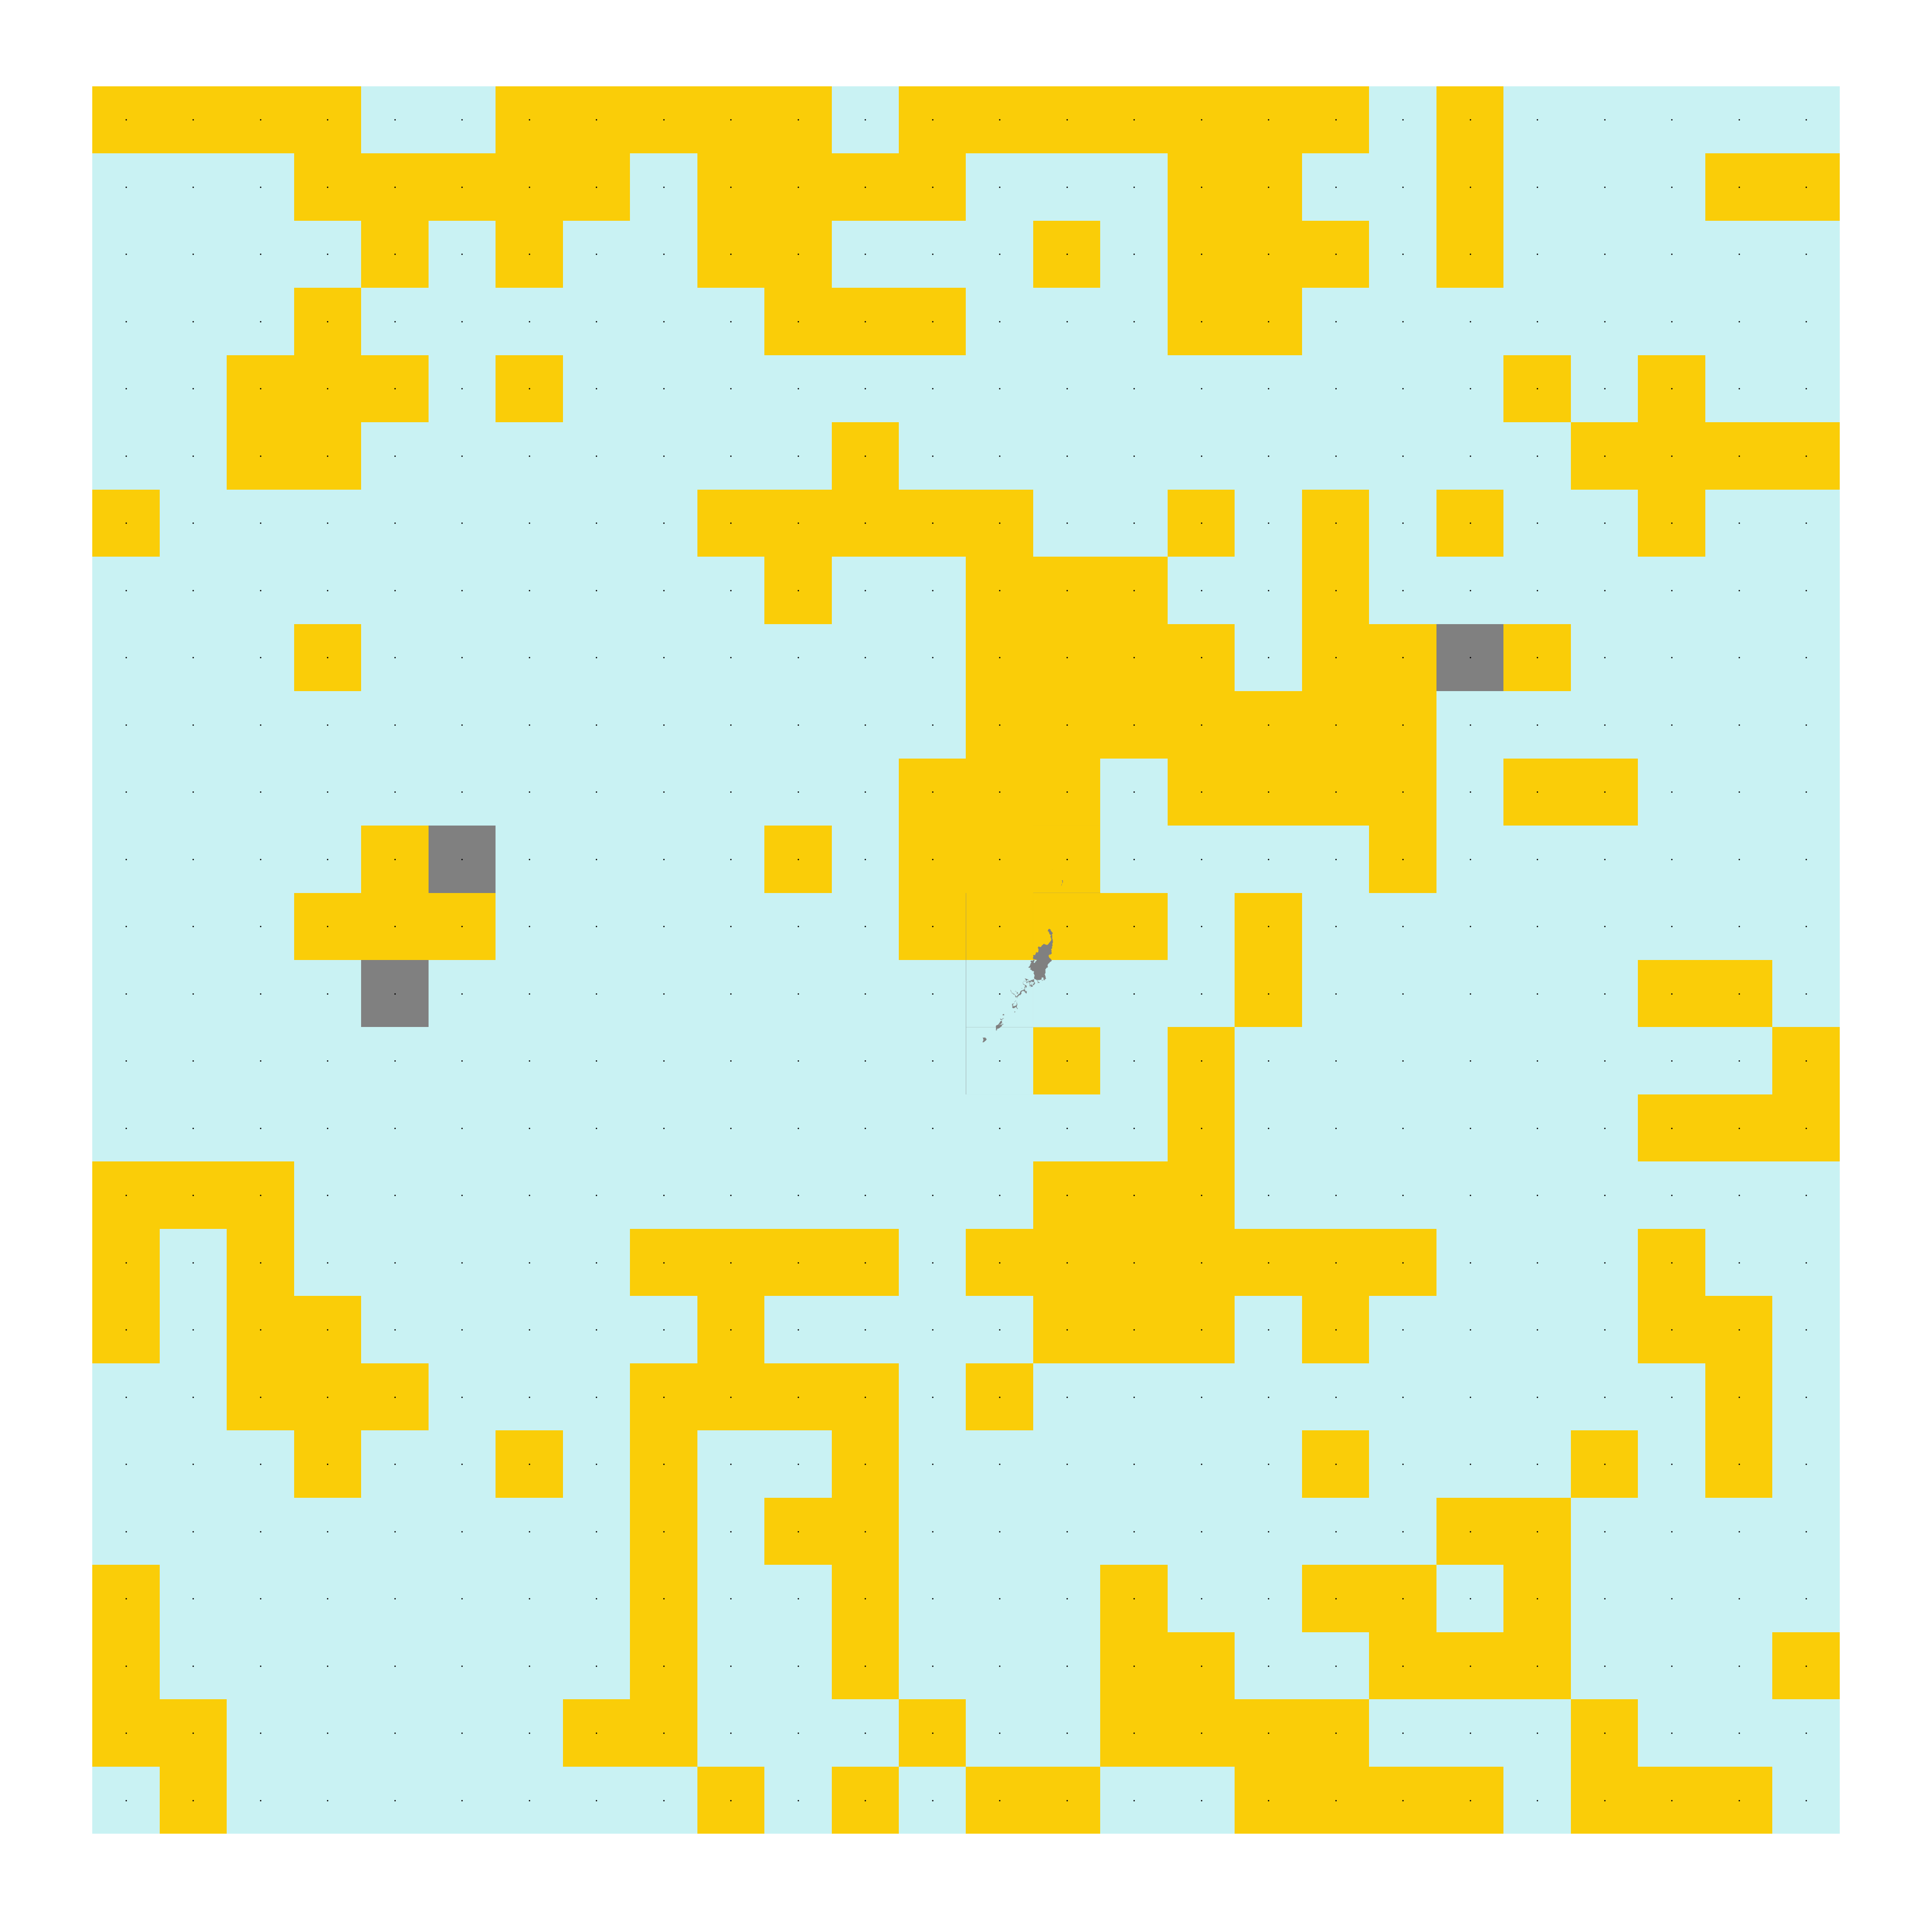

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Week_05-08/2011-07-17.json


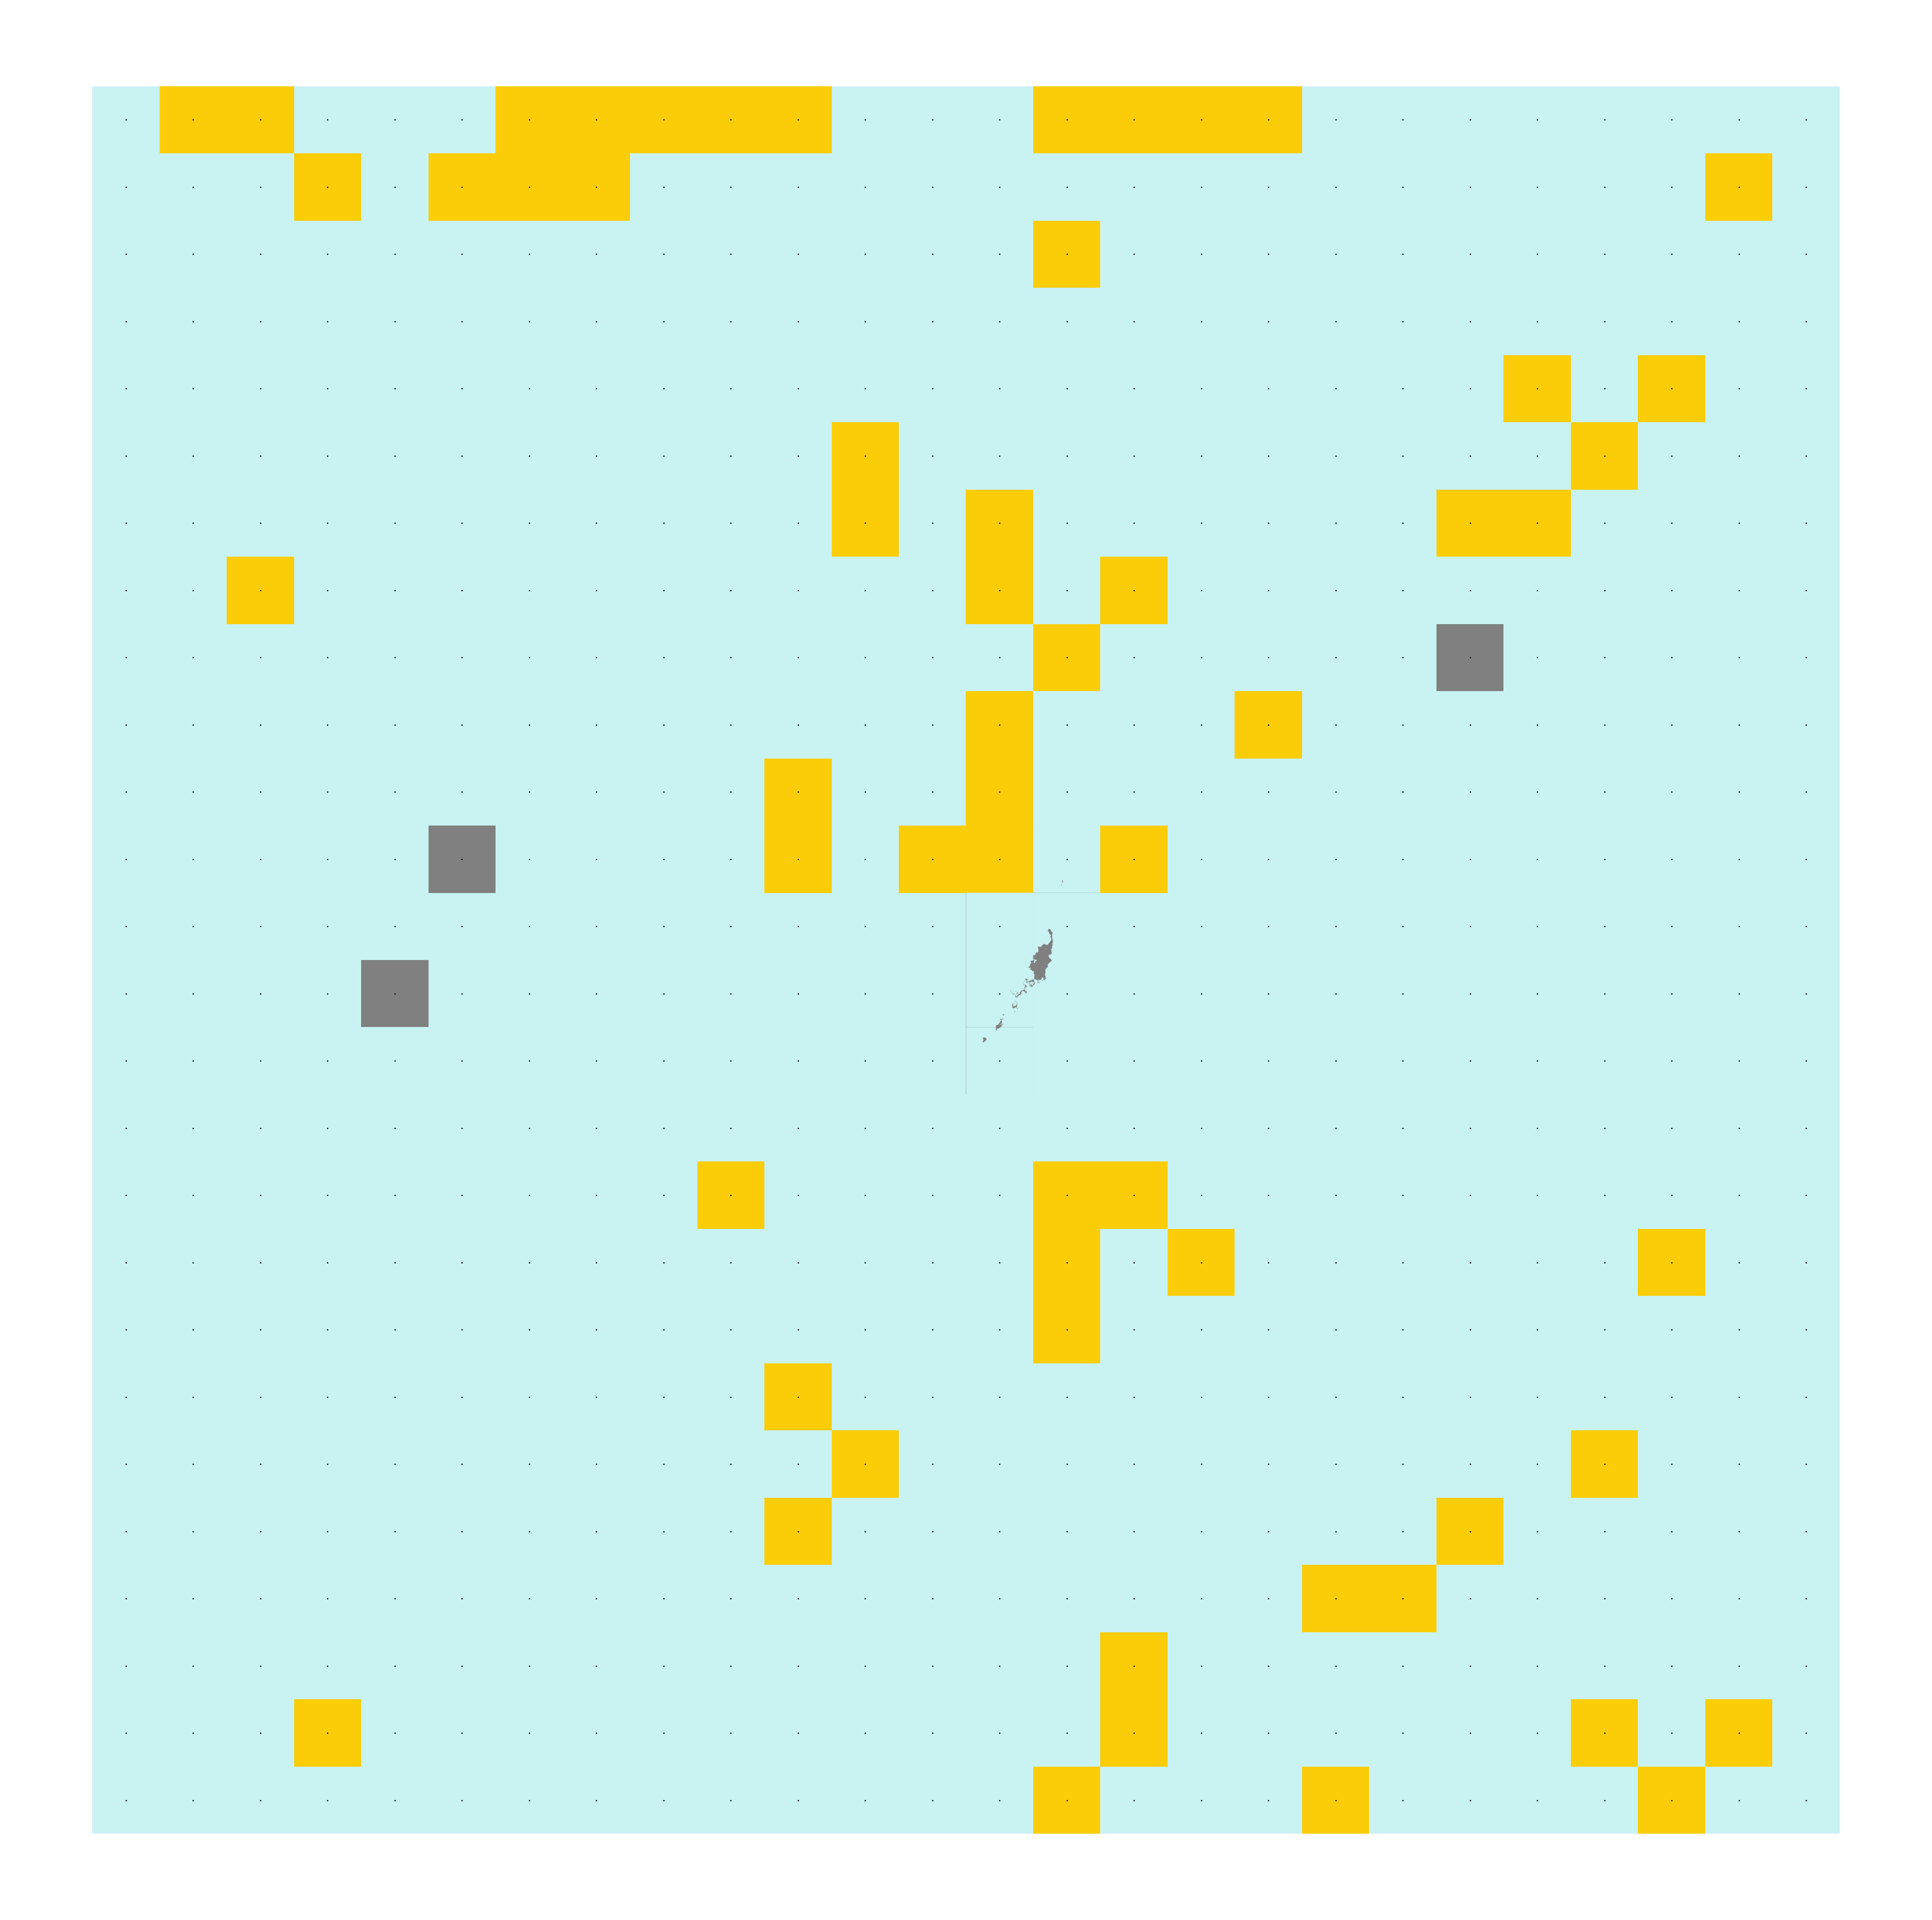

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Week_09-12/2011-07-17.json


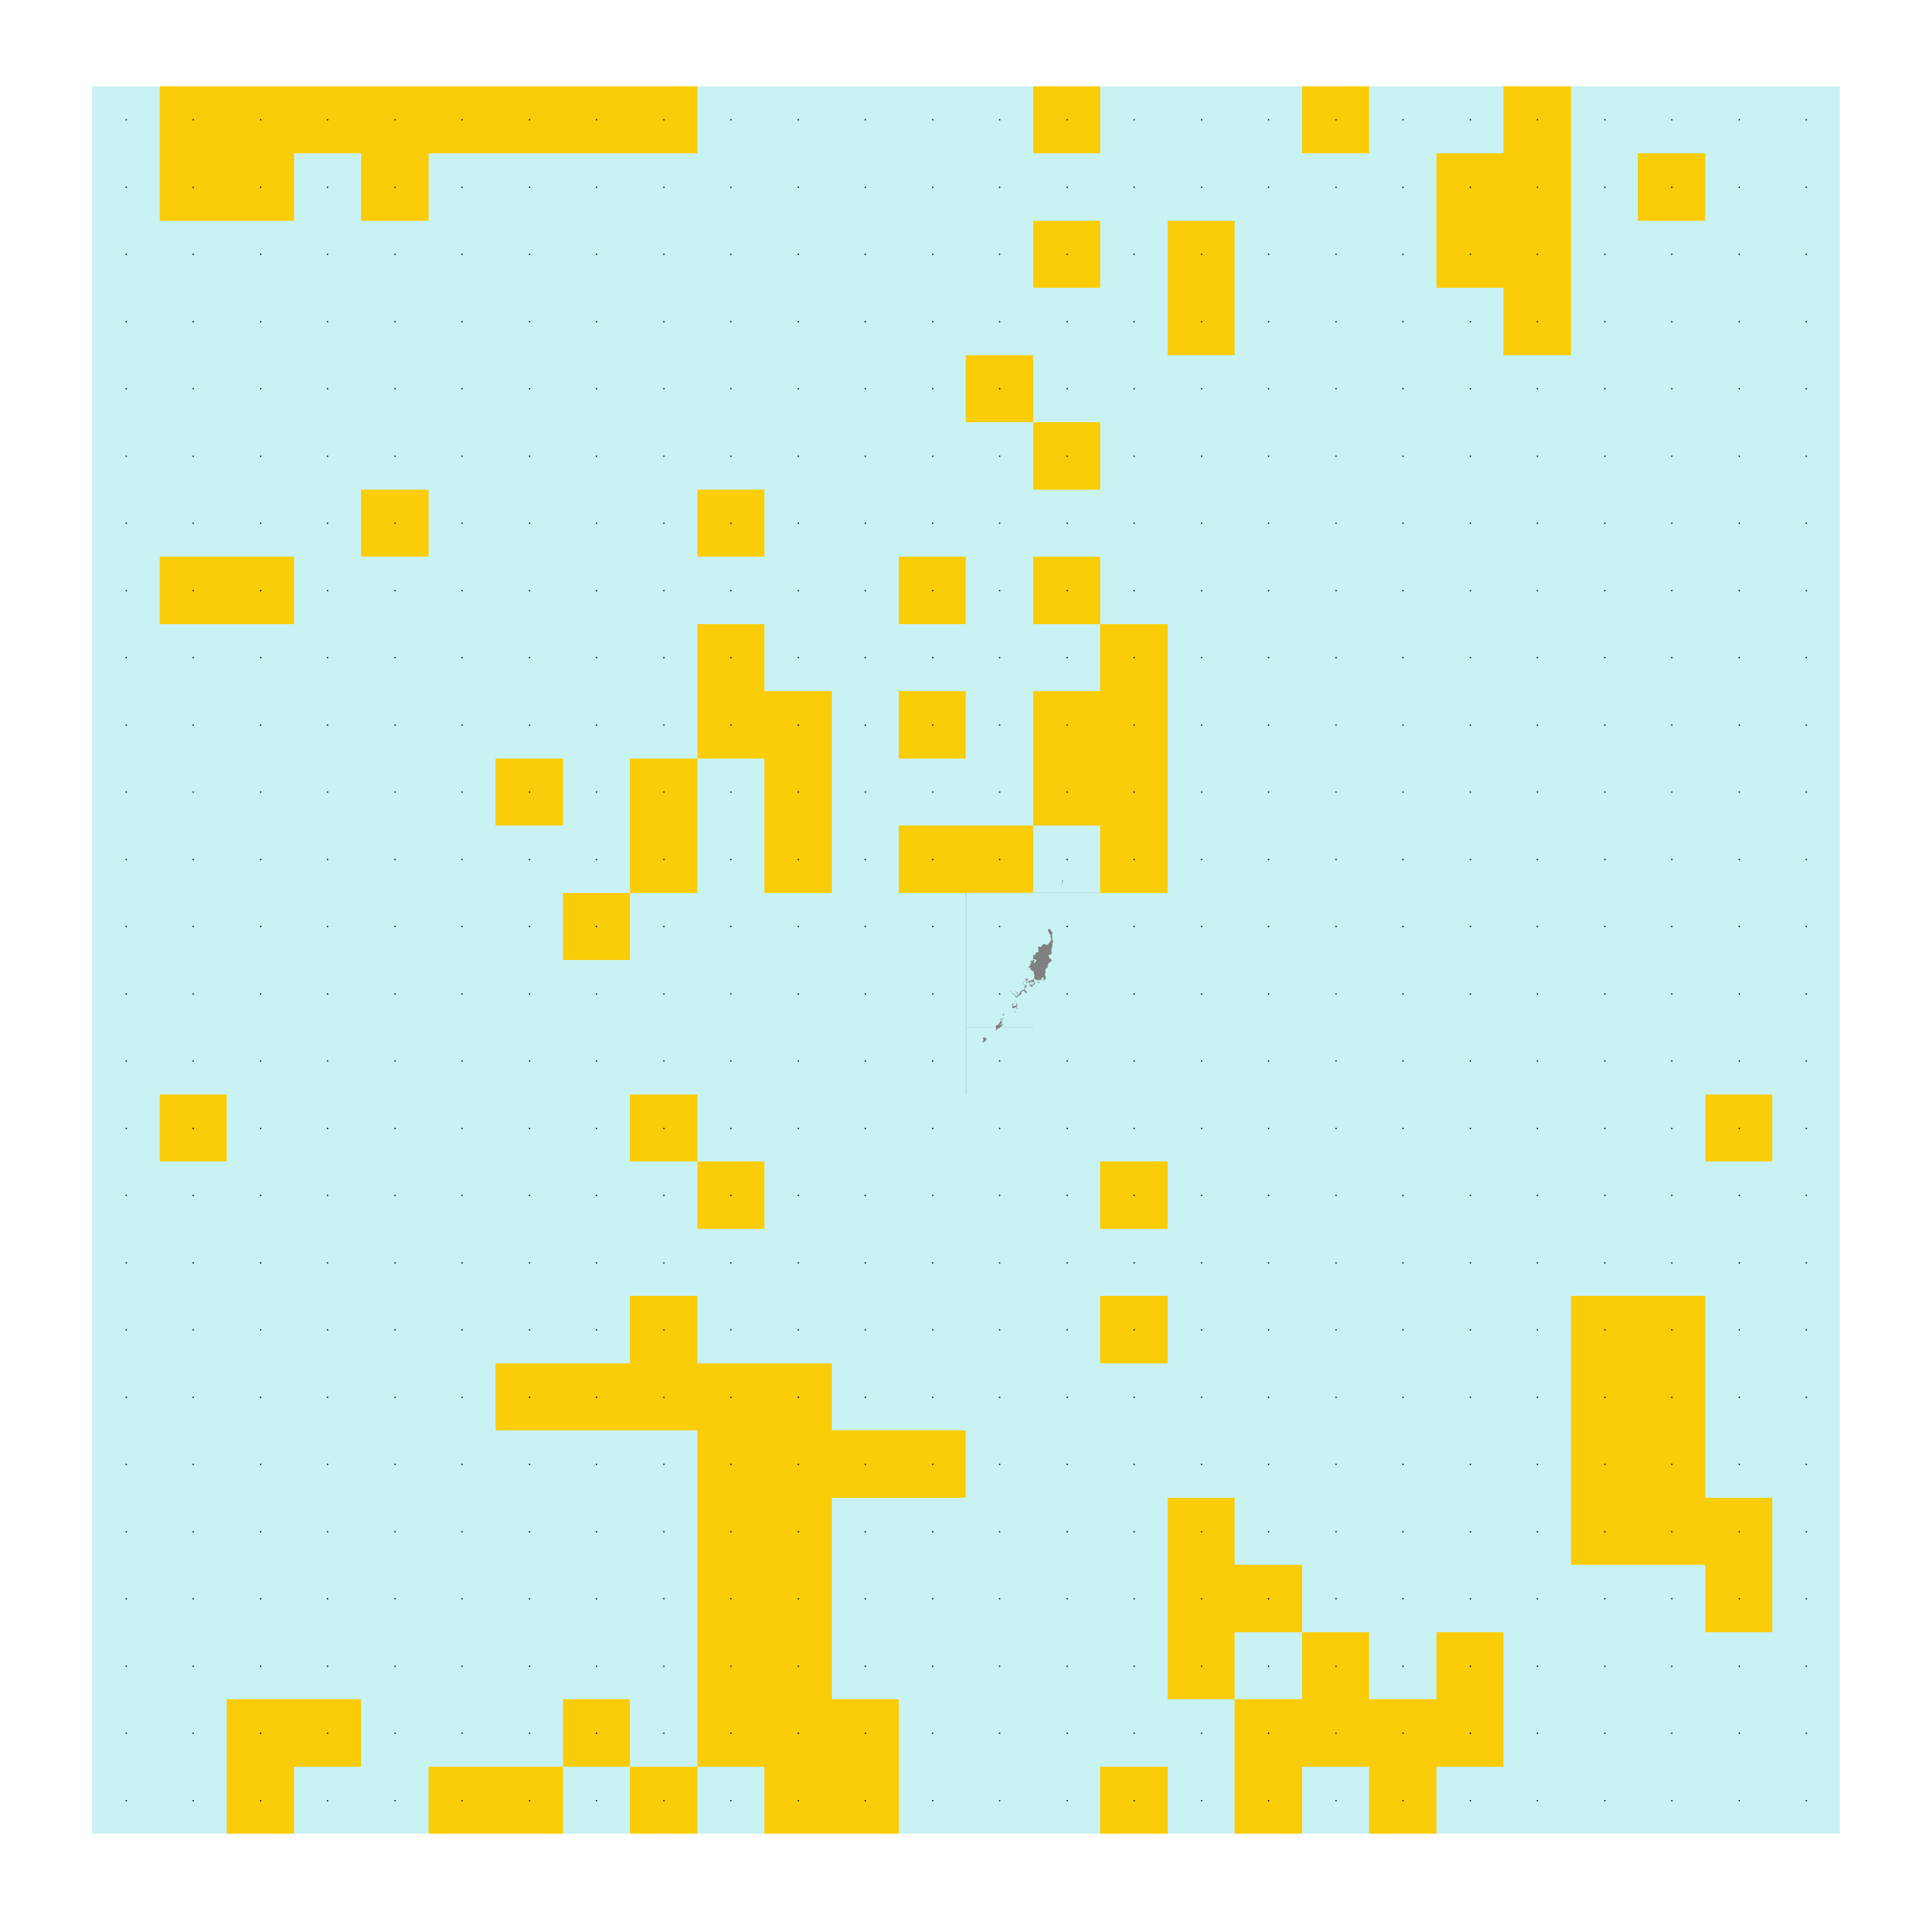

./CRW-Outlook/merged/geojson/2011/CRW_BAA_Current_Rounded/2011-07-17.json


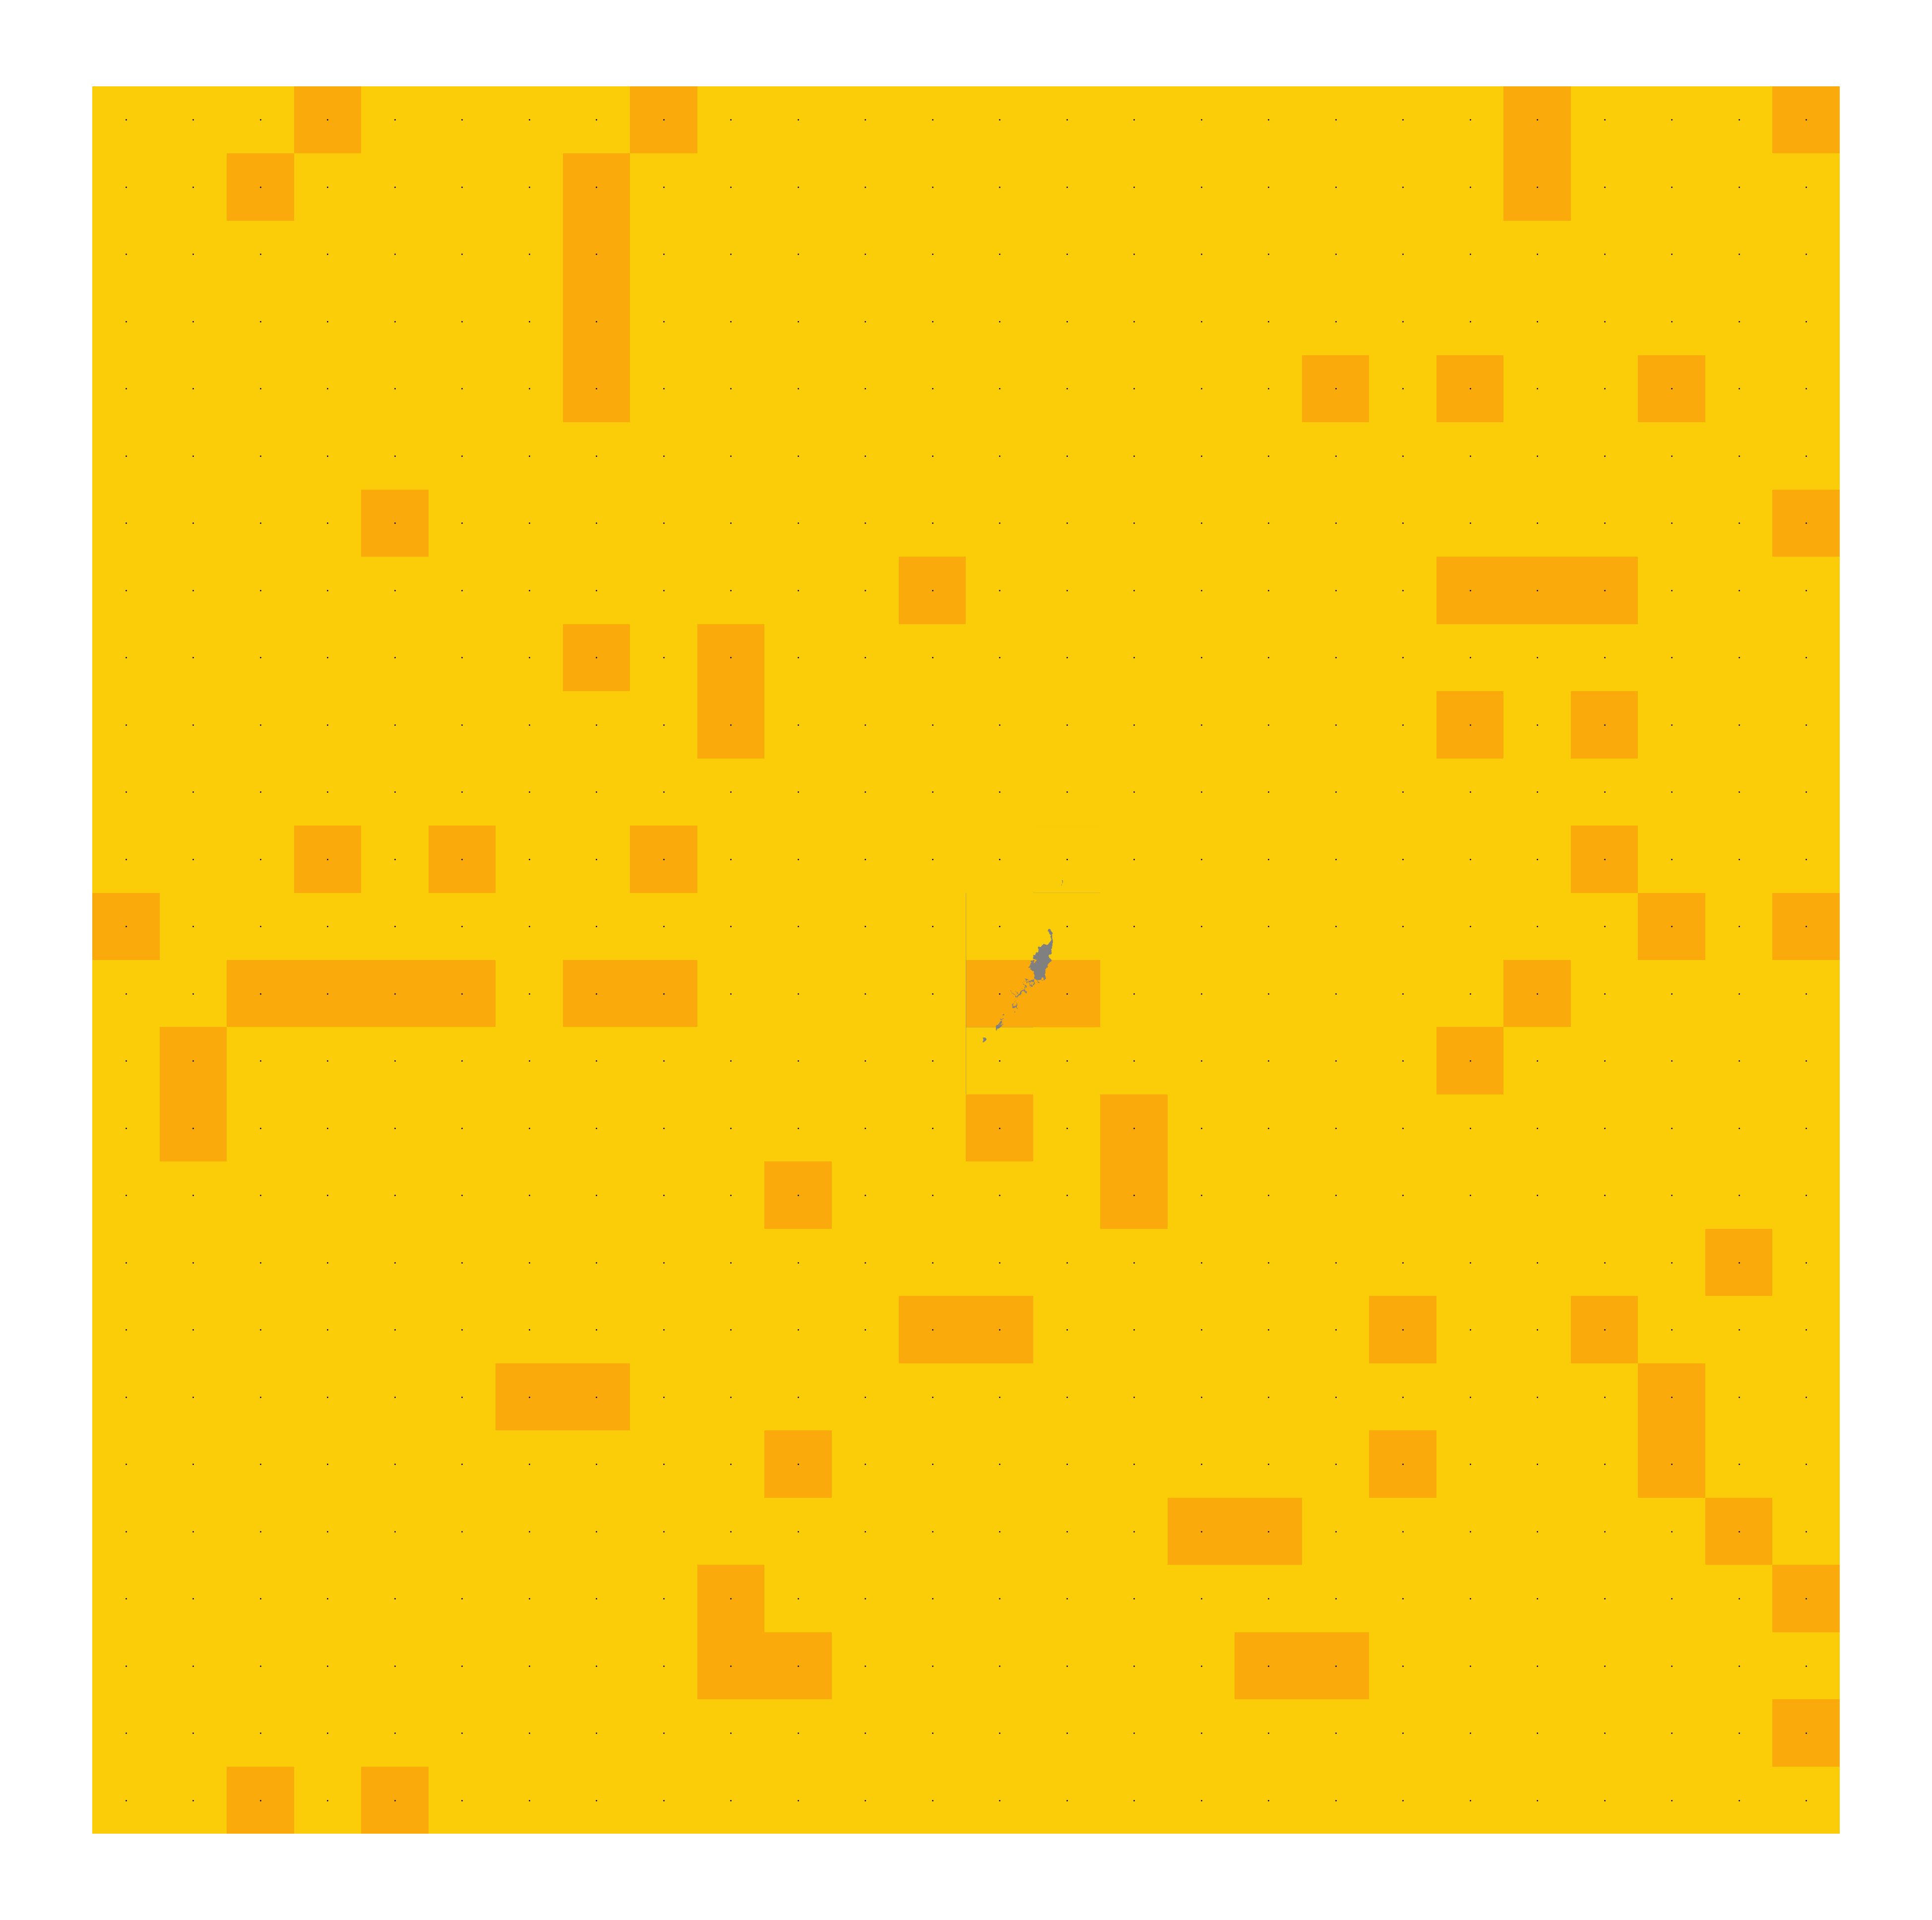

In [ ]:
if not os.path.exists('./CRW-Outlook/merged/geojson'):
    os.makedirs('./CRW-Outlook/merged/geojson')

if not os.path.exists('./CRW-Outlook/merged/colorbar'):
    os.makedirs('./CRW-Outlook/merged/colorbar')
    
colorbar_mpl('./CRW-Outlook/merged/colorbar/CRW-Outlook.png')

pkl_folders = os.listdir('./CRW-Outlook/box/pkl')
pkl_folders.sort()



dials = ['CRW_BAA_Week_01-04','CRW_BAA_Week_05-08','CRW_BAA_Week_09-12',"CRW_BAA_Current_Rounded","CRW_BAA_Current_Max","CRW_BAA_Current_Mean" ]
for year in pkl_folders:
    if not os.path.exists('./CRW-Outlook/merged/geojson/'+ year):
        os.makedirs('./CRW-Outlook/merged/geojson/'+ year)
    
    for time_range in dials:
        if not os.path.exists('./CRW-Outlook/merged/geojson/'+ year + "/" + time_range):
            os.makedirs('./CRW-Outlook/merged/geojson/'+ year + "/" + time_range)
            
    pkl_files = os.listdir('./CRW/merged/pkl/')
    pkl_files.sort()
    
    
    if year != ".DS_Store":
        for file in pkl_files:
            if file[-3:] == "pkl":
                if file[-8:-4] == year:
                    mdf = pd.read_pickle('./CRW/merged/pkl/' + file)

                    for t in list(mdf["time"].unique()):
                        df = mdf[mdf["time"] == t]
                        df = df[['lat','lon','CRW_BAA_Week_01-04','CRW_BAA_Week_05-08','CRW_BAA_Week_09-12', "CRW_BAA_Current_Rounded","CRW_BAA_Current_Max","CRW_BAA_Current_Mean"]]
                        df = df.reset_index(drop = True)
                        for time_range in dials:
                            currgeo = getGridGeoJSON(df,time_range)
                            json_object = json.dumps(currgeo, indent=4)
                            geojson_dir = './CRW-Outlook/merged/geojson/'+ year + "/" + time_range + "/" + str(t)[:10] + ".json"
                            with open(geojson_dir, "w") as outfile:
                                outfile.write(json_object)
                                print(geojson_dir)

In [44]:
file[-8:-4]

'2023'